In [1]:
import pandas as pd
import numpy as np
import rapid_review as rr
import os
import matplotlib.pyplot as plt
import importlib
from sklearn.svm import SVC, OneClassSVM
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
import ast
import random
import math
from scipy.stats import hypergeom
import seaborn as sns

## Pull the document metadata from the xml files from the Pubmed API

In [2]:
document_index = None

for fpath in os.listdir('../data/'):
    if "cohen_all" in fpath:
        ndf = rr.parse_pmxml(f'../data/{fpath}')
    if document_index is None:
        document_index = ndf
    else:
        document_index = pd.concat([document_index,ndf])
        
document_index["text"] = document_index["ab"] + document_index["mesh"]
document_index = document_index.drop_duplicates()
print(document_index.shape)
document_index.head()

(17238, 5)


,ab,PMID,ti,mesh,text
0,"This randomized, double-blind, placebo-control...",9793700,Effect of subcutaneous naratriptan on forearm ...,MESHHEADD000328 MESHHEADD001794 MESHHEADD0185...,"This randomized, double-blind, placebo-control..."
1,A multicenter test was conducted to investigat...,9793701,Effect of operationalized computer diagnosis o...,MESHHEADD000293 MESHHEADD000328 MESHHEADD0004...,A multicenter test was conducted to investigat...
2,Subcutaneous injection of sumatriptan is an ef...,9793702,Sumatriptan nasal spray (20 mg/dose) in the ac...,MESHHEADD000280 MESHHEADD000328 MESHHEADD0003...,Subcutaneous injection of sumatriptan is an ef...
3,The efficacy and adverse effects of 0.25% apra...,9793771,The effect of 0.25% apraclonidine in preventin...,MESHHEADD000316 MESHHEADD000319 MESHHEADD0003...,The efficacy and adverse effects of 0.25% apra...
4,To determine if an intravenous (i.v.) fluid bo...,9793807,An intravenous fluid bolus is not necessary be...,MESHHEADD000328 MESHHEADD015360 MESHHEADD0163...,To determine if an intravenous (i.v.) fluid bo...


In [3]:
np.sum(rr.ci_ac(0,20,0.5))

0.026759466147936353

## Load the cohen database of SRs
https://dmice.ohsu.edu/cohenaa/systematic-drug-class-review-data.html

In [4]:
cohen_db = pd.read_csv(
    '../data/epc-ir.clean.tsv',
    sep='\t',header=None,
    #names=["review","EID","PMID","relevant","fulltext_relevant"]
    names=["review","EID","PMID","relevant_ab","relevant"]
)

cohen_db['relevant'] = np.where(cohen_db['relevant']=="I",1,0)
cohen_db = cohen_db[["review","PMID","relevant"]]

cohen_db.head()



,review,PMID,relevant
0,ACEInhibitors,10024335,0
1,ACEInhibitors,10027665,0
2,ACEInhibitors,10027935,0
3,ACEInhibitors,10028936,0
4,ACEInhibitors,10029645,0


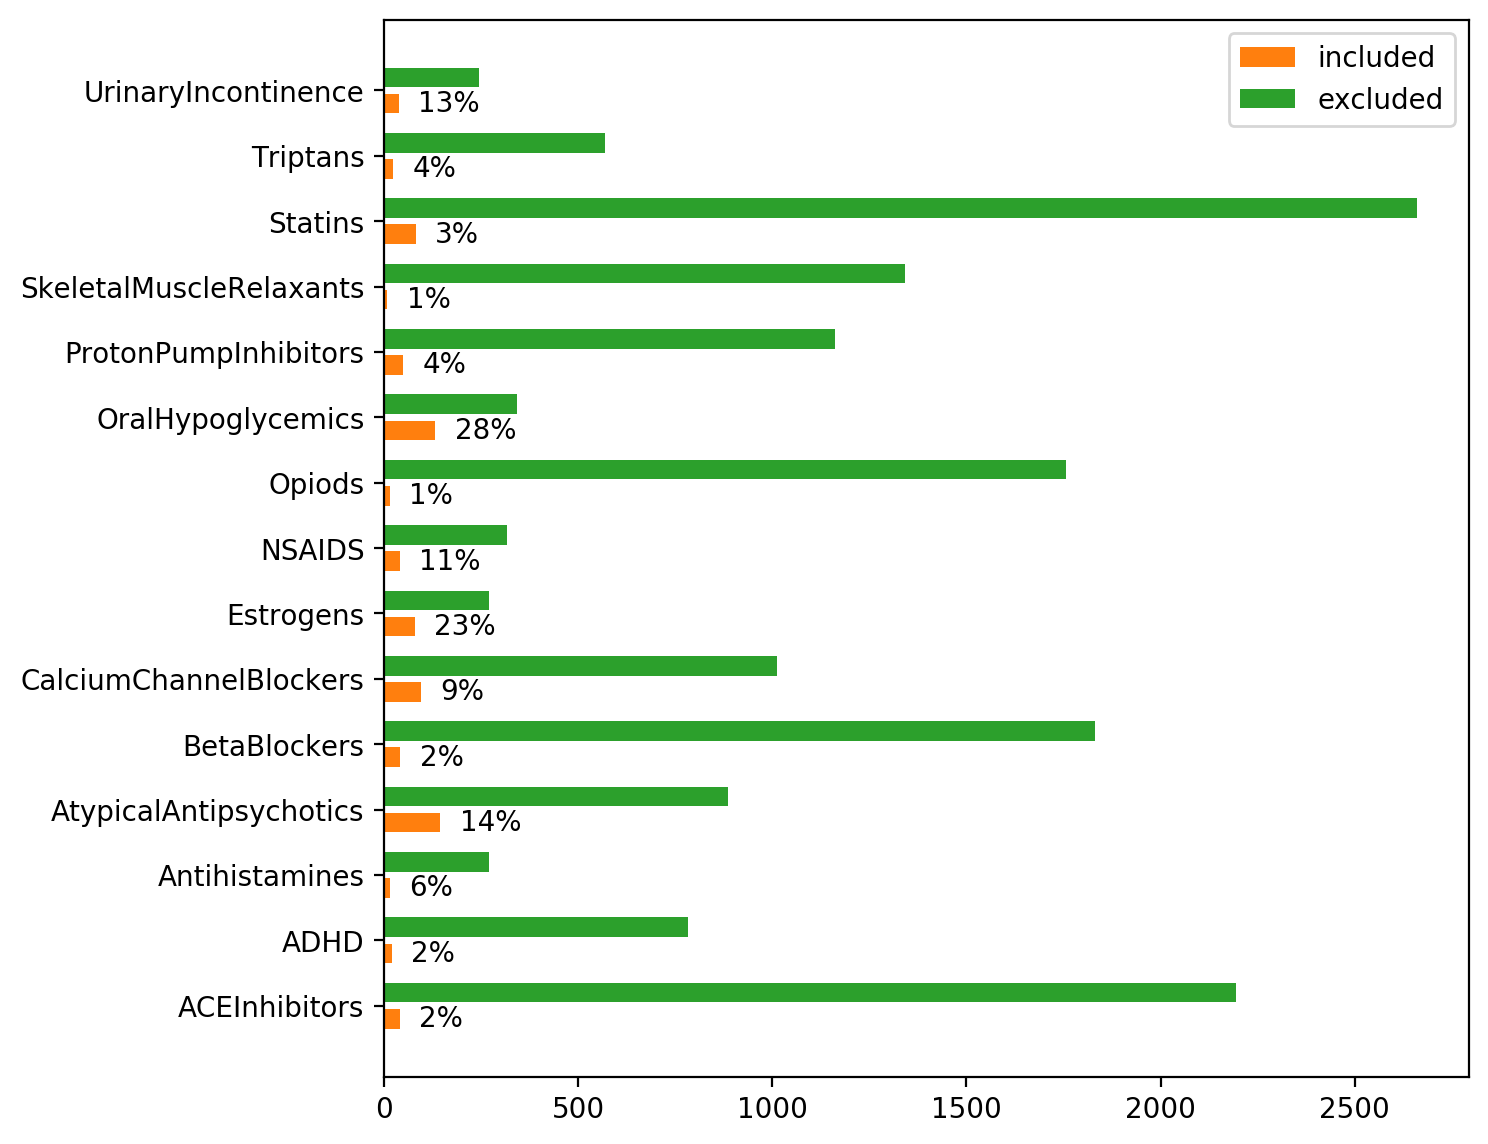

In [5]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)

cm = plt.cm.RdYlBu


ticklabels = []
for i, (name, group) in enumerate(cohen_db.groupby('review')):
    if i==0:
        l1="included"
        l2="excluded"
    else:
        l1 = None
        l2 = None
        
    group = pd.merge(
        group,
        document_index,
    )
    group = group.dropna()
    included = group[group['relevant']==1].shape[0]
    excluded = group[group['relevant']==0].shape[0]
    ax.barh(i-0.2, included, height=0.3, color='C1',label=l1)
    ax.barh(i+0.2, excluded, height=0.3, color='C2', label=l2)
    ax.text(included+50, i-0.2, f'{included/(included+excluded):.0%}', ha="left", va="center")
    ticklabels.append(name)
        
ax.set_yticks([i for i,v in enumerate(ticklabels)])
ax.set_yticklabels(ticklabels)

ax.legend()
    
    
plt.show()

In [13]:
importlib.reload(rr)

recalculate = False
if recalculate:
    models = [
        SVC(kernel='linear',class_weight='balanced',probability=True)
        #MultinomialNB(alpha=0.1)    
        #None
        #MLPClassifier(
        #    solver='lbfgs', 
        #    alpha=0.1,
        #    hidden_layer_sizes=(10), 
        #    random_state=1
        #)
    ]

    results = []
    rs_results = []
    paths = []
    iterations = 5

    for name, group in cohen_db.groupby('review'):
        df = pd.merge(
            group,
            document_index,
        )
        df['x'] = df['mesh'].str.cat(df['ab'],sep = " ")
        df = df[df['x']!=" "]
        df = df.dropna().reset_index(drop=True)
        #if df.shape[0] > 1000:
            #continue
        #if name not in ["Statins"]:#,"BetaBlockers"]:
        #    continue
        ss = rr.ScreenScenario(
            df, models, 200, [50,100,200], name
        )
        for i in range(iterations):
            results.append(ss.screen(i, True, alpha=0.95, max_switch=1))
            #print(ss.recall_rs)
        break

    results_df = pd.DataFrame.from_dict(results)

    
else:
    dfs = []
    for suffix, label in [("","cohen"), ("_pb_copd","copd_pb")]:#, ("_fr", "fastread")]:
        df = pd.read_csv(f'../results/results{suffix}.csv')
        df['data_source'] = label
        #df = df[df['iteration']<=9]
        #print(df['iteration'].max())
        dfs.append(df)
    results_df = pd.concat(dfs)
    print(results_df.shape)
    for p in ["nr_prob_target_path","prob_target_path", "recall_track", "work_track","random_work_track","random_recall_track"]:
        try:
            results_df[p] = results_df[p].str.replace("nan","0").apply(ast.literal_eval)
        except:
            print(p)
    results_df.groupby("data_source")['iterations'].sum()


/home/max/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



(420, 83)
nr_prob_target_path
prob_target_path


In [14]:
results_df

,N,X_sample,X_sample_path,alpha,bir,bir_upperbound,data_source,dataset,estimated_p_path,estimated_p_ub,...,wss_bir,wss_bir_ci,wss_hyper,wss_ih,wss_ih_100,wss_ih_200,wss_ih_50,wss_nrs,wss_pf,wss_rs
0,2234,21.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,0.095,0.144293,cohen,ACEInhibitors,"[0.832500514520587, 0.7097727477840312, 0.6174...",0.075201,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2234,22.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...",NaN,0.070,0.114940,cohen,ACEInhibitors,"[0.832500514520587, 0.7097727477840312, 0.6174...",0.075201,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2234,25.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...",NaN,0.035,0.071846,cohen,ACEInhibitors,"[0.832500514520587, 0.7097727477840312, 0.6174...",0.075201,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2234,24.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,0.090,0.138491,cohen,ACEInhibitors,"[0.832500514520587, 0.7097727477840312, 0.6174...",0.075201,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2234,28.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...",NaN,0.070,0.114940,cohen,ACEInhibitors,"[0.832500514520587, 0.7097727477840312, 0.6174...",0.075201,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,4108,3.0,NaN,0.95,0.074,0.100560,copd_pb,ProtonBeam,NaN,NaN,...,0.000000,0.0,0.535297,NaN,0.688900,0.664557,0.723953,0.435735,0.774343,NaN
36,4108,2.0,NaN,0.95,0.046,0.068394,copd_pb,ProtonBeam,NaN,NaN,...,0.814021,0.0,0.558423,NaN,0.714703,0.690360,0.726874,0.470789,0.765336,NaN
37,4108,3.0,NaN,0.95,0.054,0.077711,copd_pb,ProtonBeam,NaN,NaN,...,0.777264,0.0,0.474197,NaN,0.685735,0.661392,0.739289,0.434031,0.760954,NaN
38,4108,1.0,NaN,0.95,0.056,0.080022,copd_pb,ProtonBeam,NaN,NaN,...,0.747809,0.0,0.446689,NaN,0.683544,0.619523,0.714460,0.530915,0.749270,NaN


UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U84156'), dtype('<U84156')) -> dtype('<U84156')

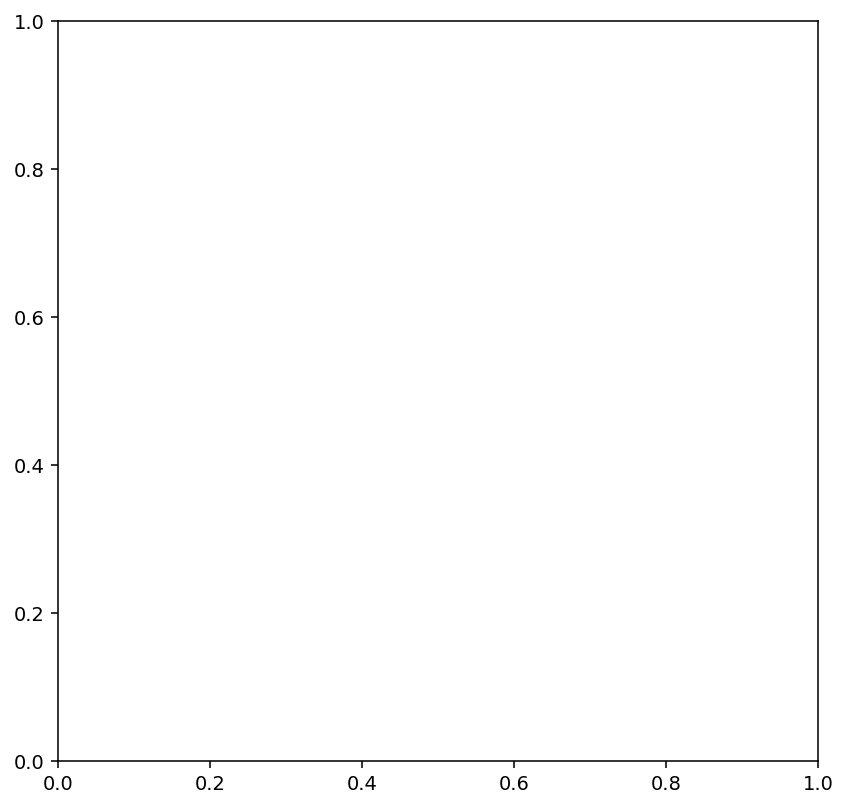

In [15]:
fig, ax = plt.subplots(figsize=(7,7),dpi=140)
for i, p in results_df[(results_df['dataset']=="ProtonBeam") & (results_df['s']==200)].iterrows():
    ax.plot(p['work_track'], 1-np.array(p['nr_prob_target_path']), c="#66c2a5", alpha=0.4)
    ax.plot(p['work_track'], p['recall_track'], c="#66c2a5", alpha=0.4)
    #ax.plot(p['recall_track'], p['nr_prob_target_path'])
    
    ax.axhline(0.05, c="grey", lw=0.5)
    ax.axhline(0.95, c="grey", lw=0.5)

    
    
ax.plot([0,1],[0,1],c="grey", lw=0.5)
    
plt.show()

In [16]:
crit = ["bir", "ih_50", "ih_200", "hyper","nrs"]

for s in crit:
    p = results_df[results_df[f'recall_{s}']>0.95].shape[0]/results_df.shape[0]
    print(f"{s}: above threshold {p:.2%}")

bir: above threshold 65.71%
ih_50: above threshold 56.19%
ih_200: above threshold 89.29%
hyper: above threshold 98.33%
nrs: above threshold 100.00%


In [ ]:

#plt.boxplot(pdf['random_start_recall'])
#plt.scatter([0]*len(pdf['recall_hyper']),pdf['recall_hyper'])
#plt.scatter(pdf['iteration']+0.1,pdf['recall_hyper'])
#plt.scatter(pdf['iteration'],pdf['hyper_uinterval'])
#plt.scatter(pdf['iteration'],pdf['hyper_linterval'])

#plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(7,7),dpi=140)
colors = ['#66c2a5','#fc8d62','#8da0cb']

a = 0.3
size = 15

pdf = results_df[results_df['N'] > 2000]

for i, p in pdf.iterrows():

    ax.plot(p['work_track'], p['recall_track'], c = colors[0], alpha=a)
    ax.plot(p['random_work_track'], p['random_recall_track'], c = colors[0], alpha=a, linestyle="--")
    #ax.plot(p['random_work_track'], p['estimated_recall_path'])
    #ax.plot(p['random_work_track'], p['estimated_p_path'])
    
s_crit = ["bir","ih_50", "hyper", "nrs"]

import itertools
marker = itertools.cycle((',', '+', 'v', 'o', '*',':')) 

ax.scatter(pdf['random_start_work'],pdf['random_start_recall'],c=colors[0],s=size,alpha=a+0.2)

for s in s_crit:
    ax.scatter(
        1- pdf[f'wss_{s}'], 
        pdf[f'recall_{s}'], 
        c = colors[0], marker = next(marker),
        label = s,
        s = size,
        alpha=a+0.2
    )
    
ax.axhline(0.95, color="steelblue",lw=0.5)
ax.plot([0,1],[0,1], color="steelblue", lw=0.5)
ax.legend()
ax.grid()

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(7,7),dpi=140)
colors = ['#66c2a5','#fc8d62','#8da0cb']

a = 0.2
size = 15

pdf = results_df[results_df['data_source'] == "copd_pb"]

ax.axhline(0.95, color="steelblue",lw=0.5)
ax.plot([0,1],[0,1], color="steelblue", lw=0.5)
ax.grid()

ax.set_xlabel('Documents seen')
ax.set_ylabel('Recall')

plt.savefig('../images/active_learning_blank', bbox_inches="tight")

for i, p in pdf.iterrows():

    ax.plot(p['work_track'], p['recall_track'], c = colors[0], alpha=a)

plt.savefig('../images/active_learning_paths', bbox_inches="tight")

    


plt.show()

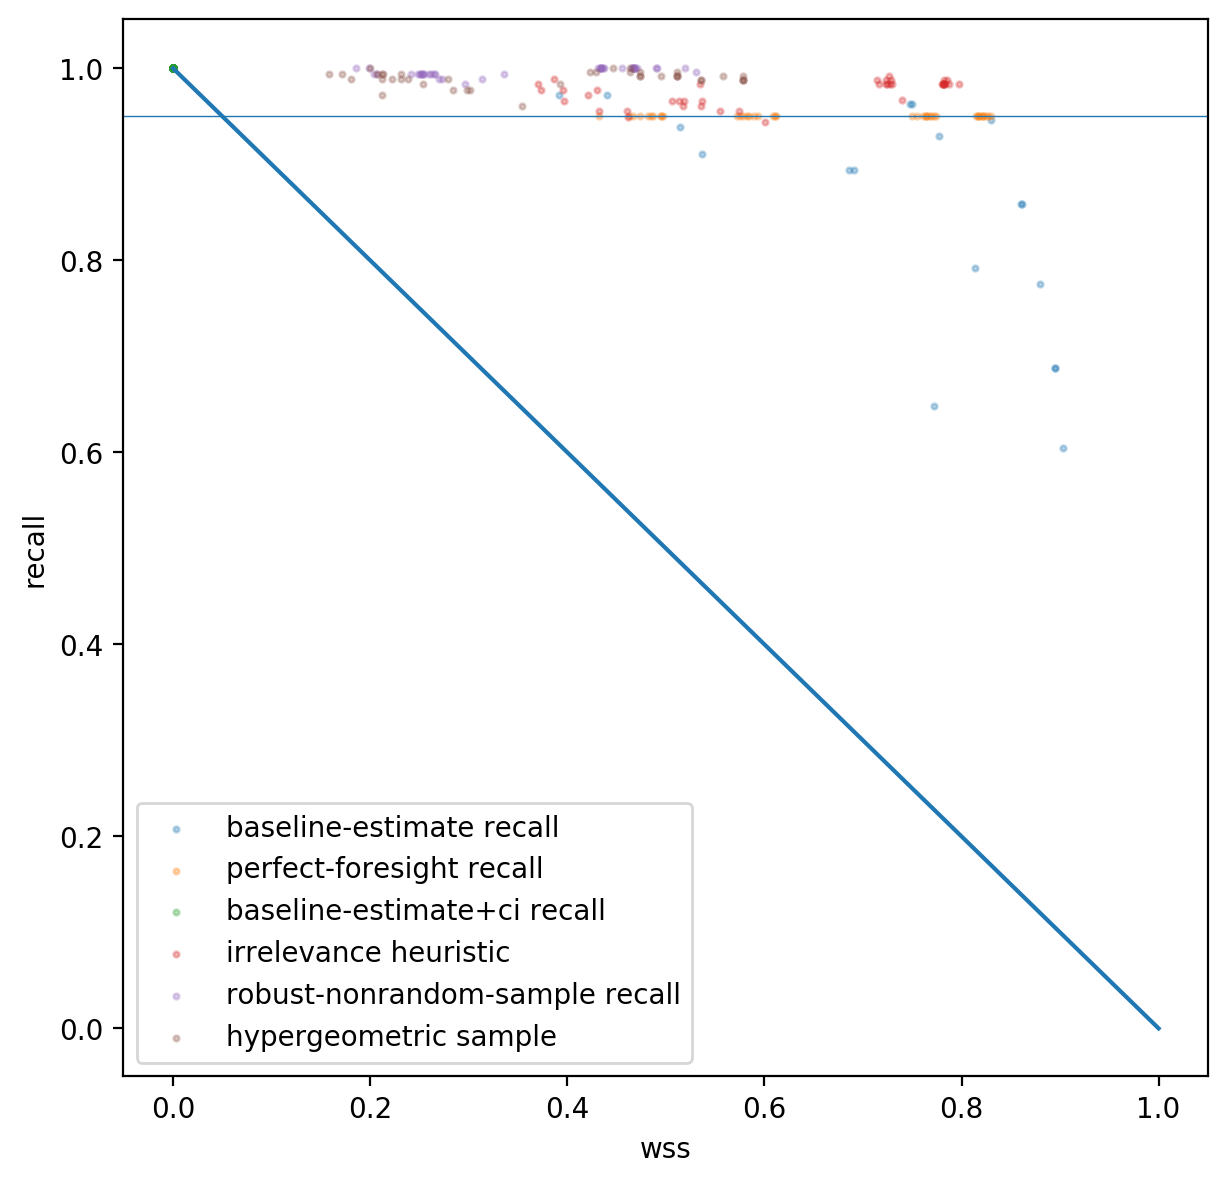

In [17]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)
s = 4
a = 0.3

pdf = results_df#[results_df['data_source']=="fr"]

ax.scatter(
    pdf['wss_bir'], pdf['recall_bir'], 
    alpha=a, 
    label="baseline-estimate recall",
    s=s
)
ax.scatter(
    pdf['wss_pf'], 
    [0.95 for x in pdf['recall_pf']], 
    alpha=a,
    label="perfect-foresight recall",
    s=s
)

ax.scatter(
    pdf['wss_bir_ci'], 
    pdf['recall_bir_ci'], 
    alpha=a,
    label="baseline-estimate+ci recall",
    s=s
)

ax.scatter(
    pdf['wss_ih_50'], 
    pdf['recall_ih_50'], 
    alpha=a,
    label="irrelevance heuristic",
    s=s
)

ax.scatter(
    pdf['wss_nrs'], pdf['recall_nrs'], 
    alpha=a, 
    label="robust-nonrandom-sample recall",
    s=s
)

ax.scatter(
    pdf['wss_hyper'], pdf['recall_hyper'], 
    alpha=a, 
    label="hypergeometric sample",
    s=s
)

ax.legend()
ax.set_ylabel('recall')
ax.set_xlabel('wss')

ax.plot([1,0],)

ax.axhline(0.95, lw=0.5)
plt.show()

In [18]:
results_df.columns

Index(['N', 'X_sample', 'X_sample_path', 'alpha', 'bir', 'bir_upperbound',
       'data_source', 'dataset', 'estimated_p_path', 'estimated_p_ub',
       'estimated_r_docs', 'estimated_recall_min', 'estimated_recall_path',
       'hyper_hypo_path', 'hyper_interval', 'hyper_linterval_path',
       'hyper_prob', 'hyper_prob_pmf', 'hyper_uinterval_path',
       'hypothetical_95', 'irrelevant_heuristic', 'iteration',
       'iteration_size', 'iterations', 'last_iteration_relevance',
       'max_min_recall_path', 'max_prob_recall', 'min_prob_target', 'models',
       'n_remaining', 'n_remaining_pre_sample', 'n_sample',
       'nr_prob_target_path', 'p', 'prob_recall_path', 'prob_target',
       'prob_target_path', 'r_docs', 'r_predicted', 'r_predicted_upperbound',
       'r_seen', 'r_seen_pre_sample', 'random_recall_track',
       'random_start_recall', 'random_start_work', 'random_work_track',
       'ratings', 'recall', 'recall_bir', 'recall_bir_ci', 'recall_hyper',
       'recall_ih_100',

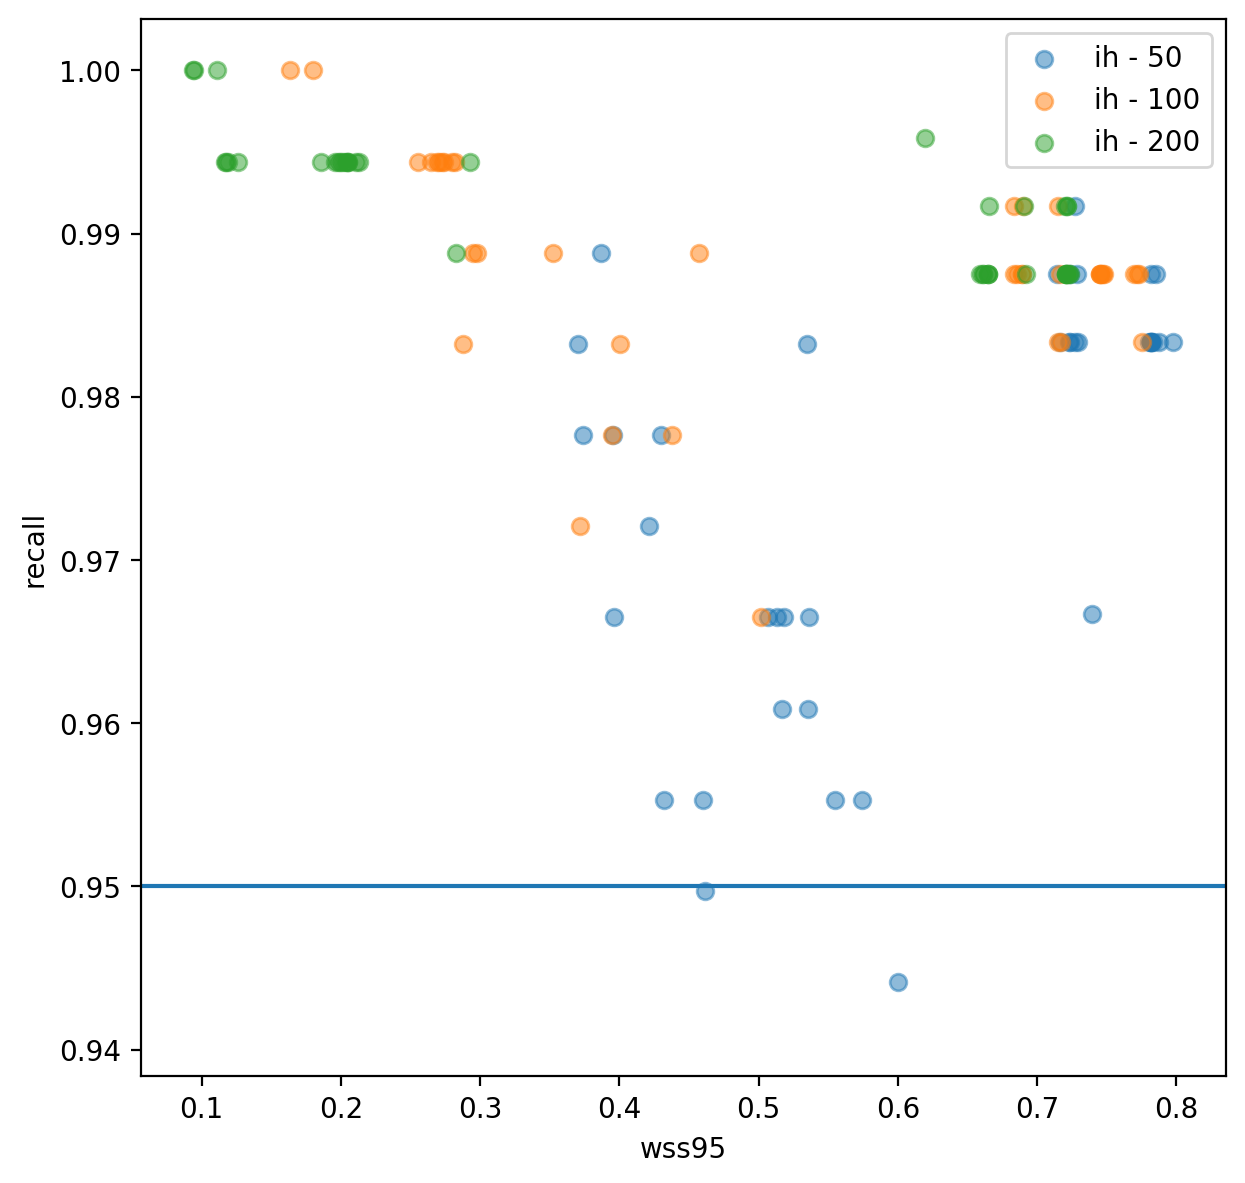

In [19]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)
for ih in [50,100,200]:
    ax.scatter(
        results_df[f'wss_ih_{ih}'], results_df[f'recall_ih_{ih}'], 
        alpha=0.5, 
        label=f"ih - {ih}"
    )


ax.legend()
ax.set_ylabel('recall')
ax.set_xlabel('wss95')

ax.axhline(0.95)
plt.savefig("../images/ih_experiment.png")
plt.show()

420
13


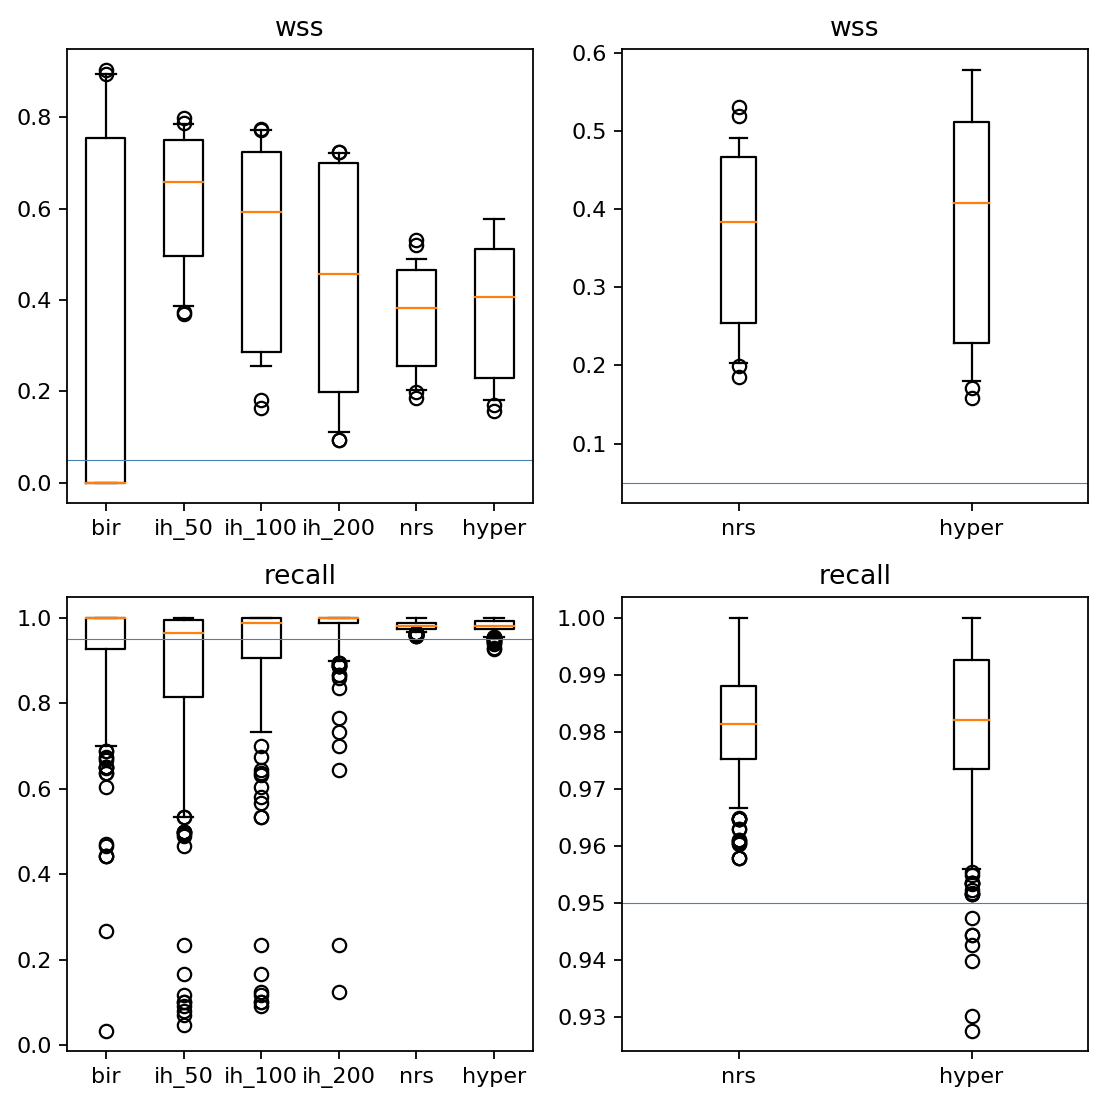

In [20]:
fig, axs = plt.subplots(2,2, figsize=(7,7),dpi=160)

s_crit = ["bir","ih_50","ih_100","ih_200", "nrs","hyper"]
rs_crit = ['nrs','hyper']

pdf = results_df[(results_df['N'] > 2000) & (pd.notnull(results_df['recall_pf']))]

pdf = results_df

print(pdf.shape[0])

print(len(pdf['dataset'].unique()))

for s in s_crit:
    pdf[f'additional_burden_f{s}'] = pdf[f"wss_{s}"] - pdf["wss_pf"]
    
for s in s_crit:
    pdf[f'missed_target{s}'] = pdf[f"recall_{s}"] - 0.95
    
    

for i, c in enumerate([s_crit, rs_crit]):
    
    for j in [(0,'wss',0.05), (1,'recall',0.95)]:

        axs[j[0]][i].boxplot([pdf[f'{j[1]}_{s}'].dropna() for s in c],whis=[5,95])
        axs[j[0]][i].set_xticklabels(c)
        axs[j[0]][i].axhline(j[2], color="steelblue",lw=0.5)
        
        axs[j[0]][i].set_title(j[1].replace('95',''))

fig.tight_layout()

plt.savefig("../images/wss_recall_boxplot.png")


plt.show()

420
13


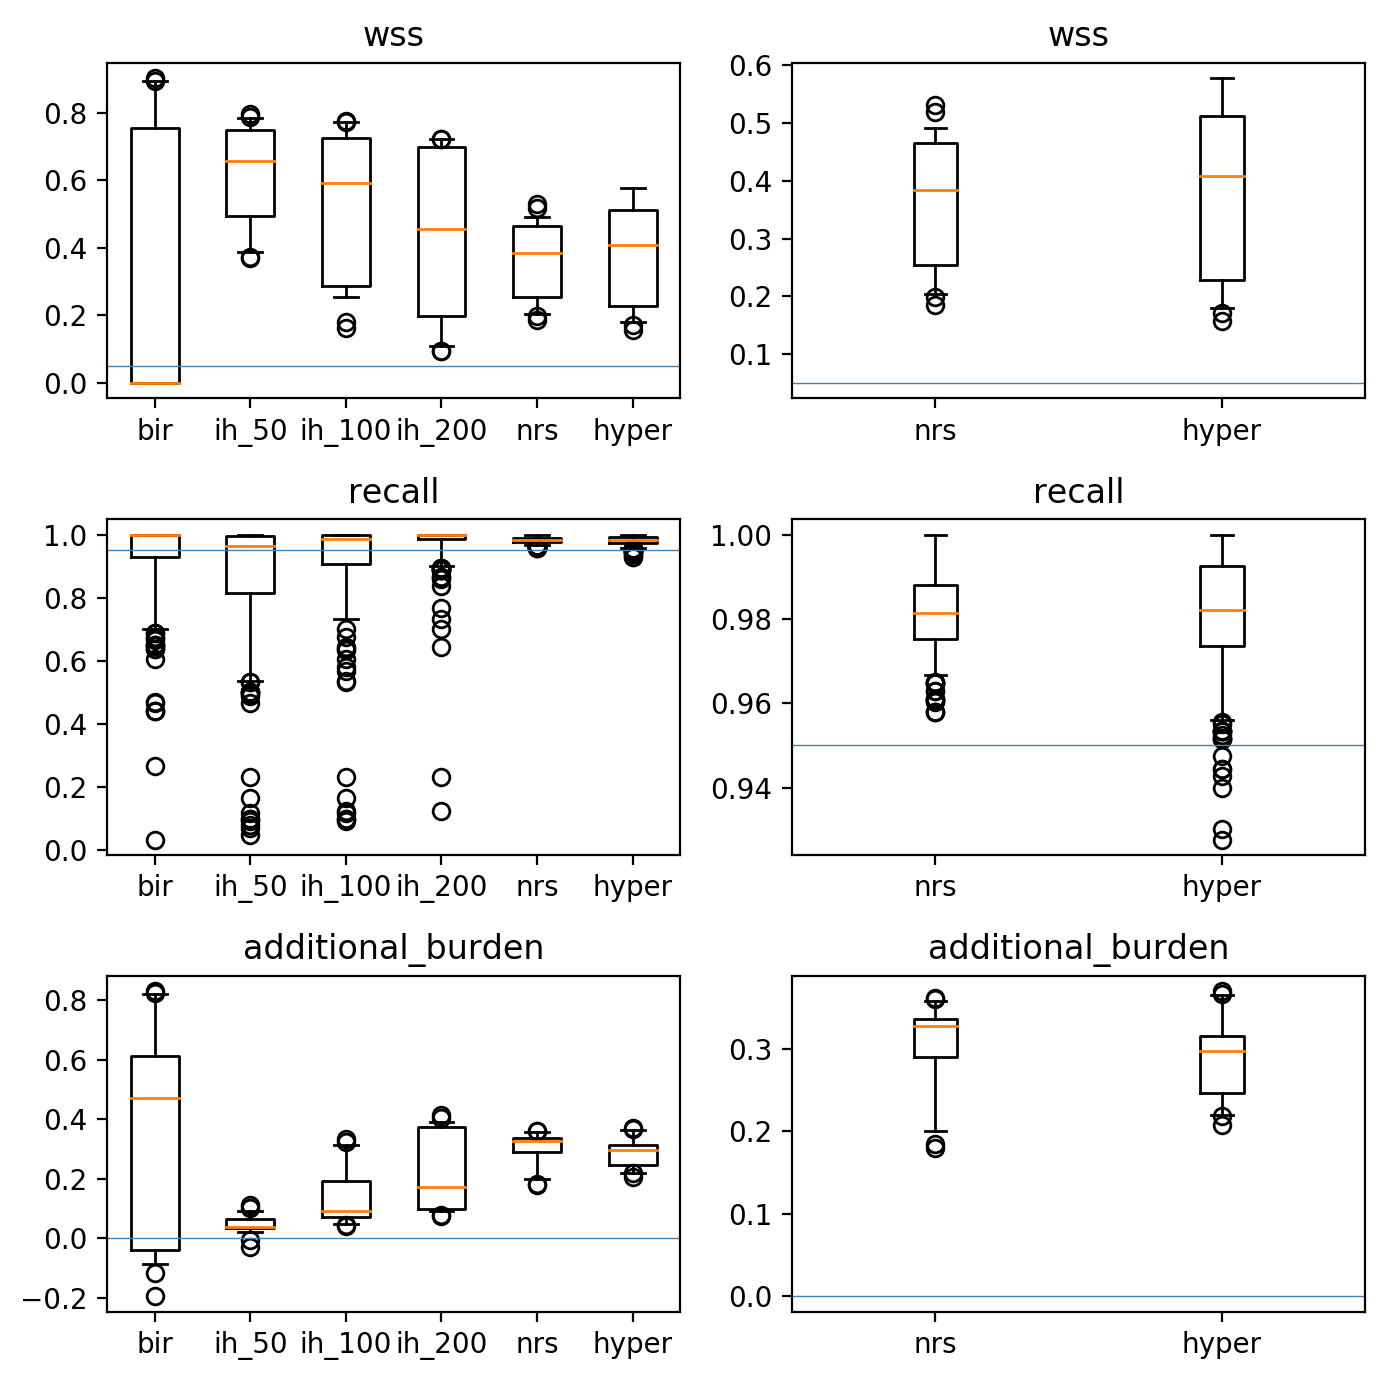

In [21]:
fig, axs = plt.subplots(3,2, figsize=(7,7),dpi=200)

rs_crit = ['nrs','hyper']

pdf = results_df[(results_df['N'] > 2000) & (pd.notnull(results_df['recall_pf']))]
pdf = results_df
print(pdf.shape[0])

print(len(pdf['dataset'].unique()))

for s in s_crit:
    pdf[f'additional_burden_{s}'] = pdf["wss_pf"] -  pdf[f"wss_{s}"]
    #pdf.loc[pdf[f'additional_burden_{s}']<0,f'additional_burden_{s}'] = 0

for s in rs_crit:
    pdf[f'additional_burden_{s}'] = pdf["wss_pf"] - pdf[f"wss_{s}"] 
    #pdf.loc[pdf[f'additional_burden_{s}']<0,f'additional_burden_{s}'] = 0
    

for i, c in enumerate([s_crit, rs_crit]):
    
    for j in [(0,'wss',0.05), (1,'recall',0.95), (2,'additional_burden',0)]:

        axs[j[0]][i].boxplot([pdf[f'{j[1]}_{s}'].dropna() for s in c],whis=[5,95])
        axs[j[0]][i].set_xticklabels(c)
        axs[j[0]][i].axhline(j[2], color="steelblue",lw=0.5)
        
        axs[j[0]][i].set_title(j[1].replace('95',''))

fig.tight_layout()

plt.savefig("../images/wss_recall_burden_boxplot.png")


plt.show()

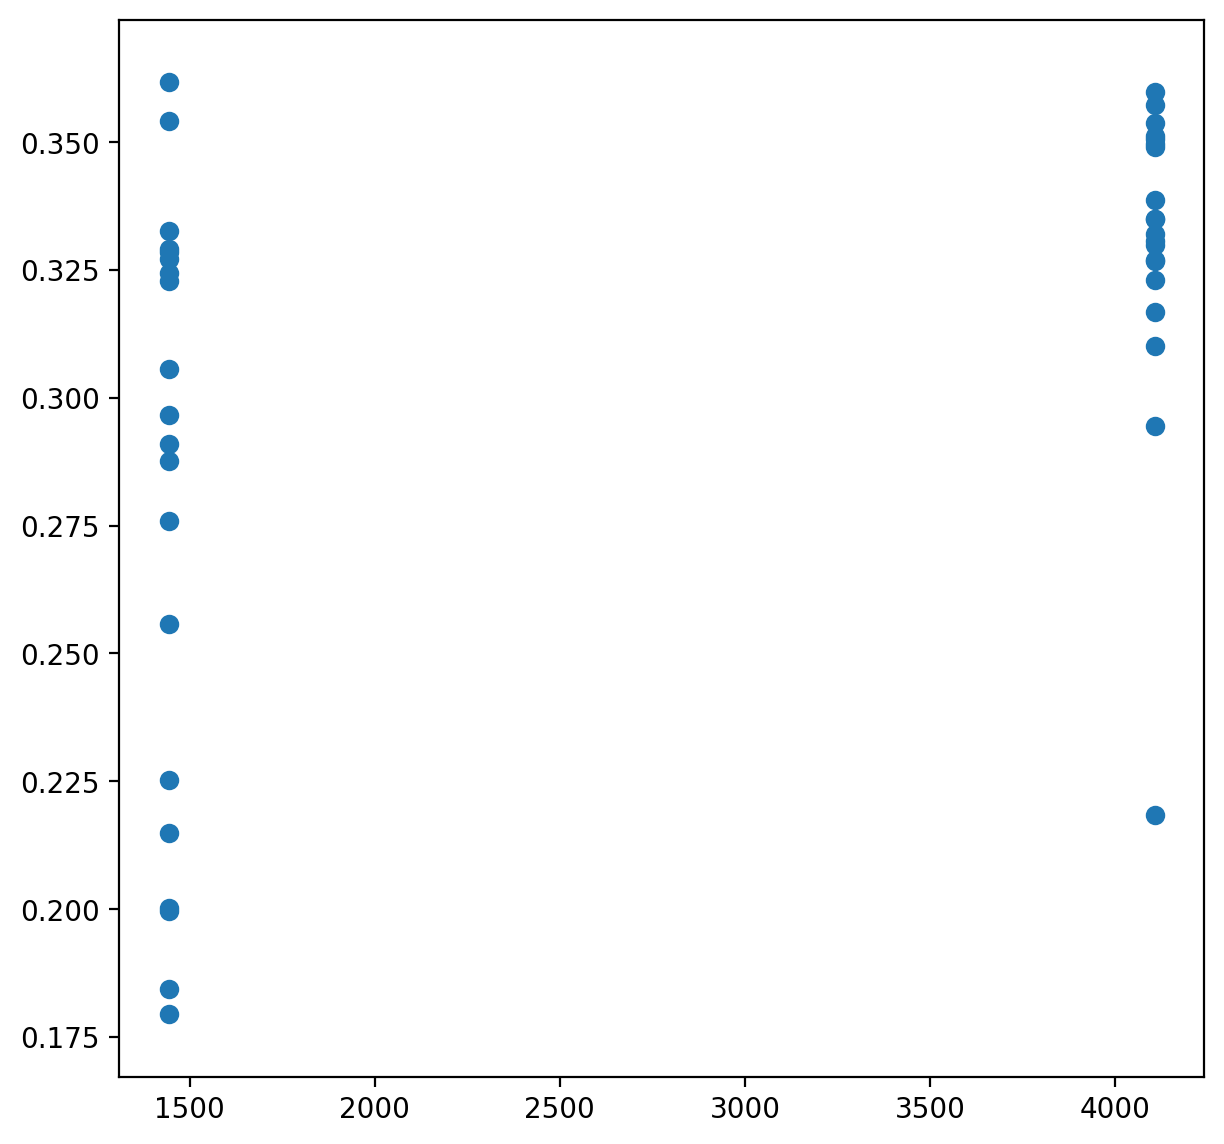

In [22]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)

ax.scatter(pdf['N'],pdf['additional_burden_nrs'])

additional burden for nrs depends on
- number of relevant documents
- number of irrelevant documents?

ValueError: operands could not be broadcast together with shapes (40,) (420,) 

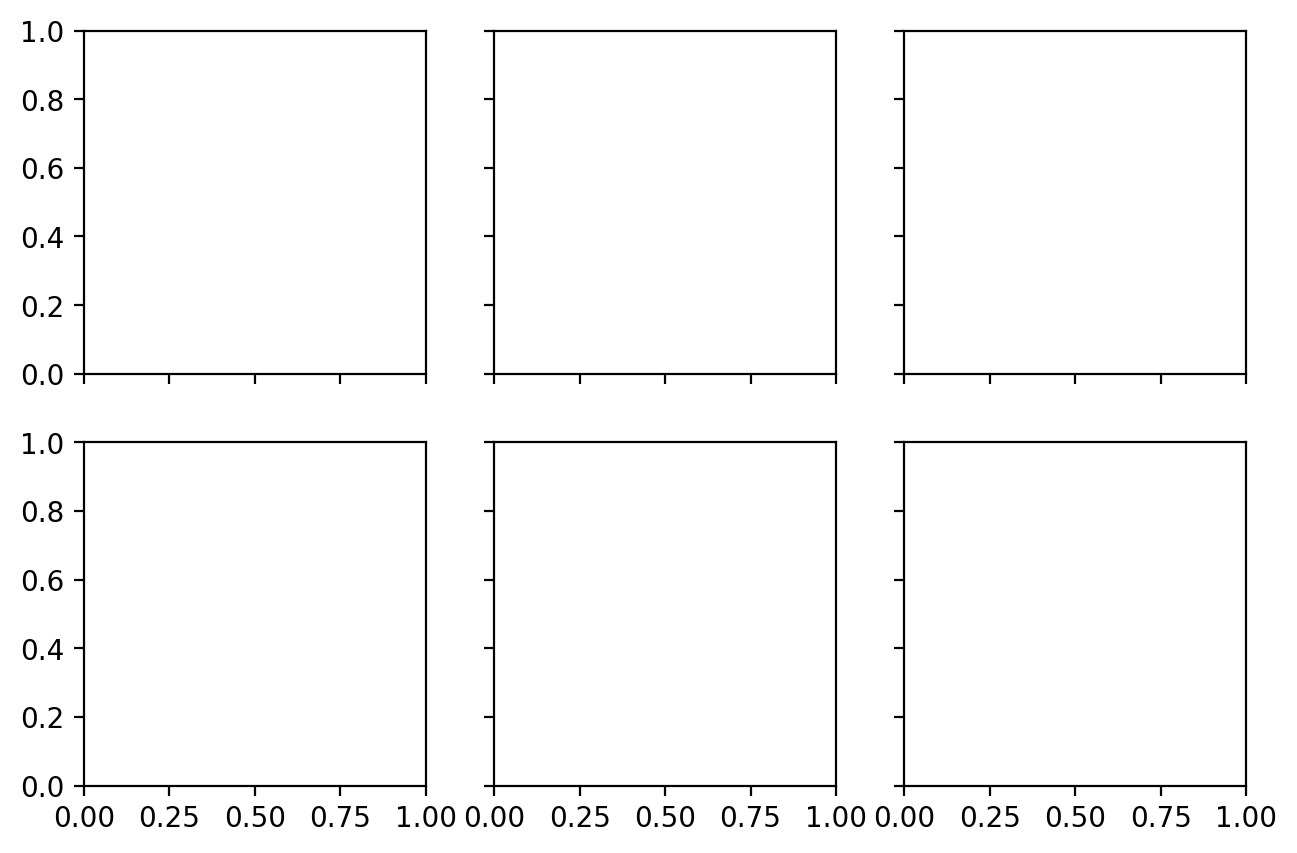

In [23]:
fig, axs = plt.subplots(2,3,figsize=(7.5,5),dpi=200,sharey=True, sharex=True)

cols = [f'wss_{s}' for s in s_crit] + [f'recall_{s}' for s in s_crit]

#pdf = results_df[results_df['data_source']=="copd_pb"][cols].dropna()
#pdf = results_df[results_df['data_source']=="copd_pb"][cols].dropna()
pdf = results_df

s_crit = ["bir","ih_50","hyper","ih_100", "ih_200", "nrs"]

for i, ss in enumerate(s_crit):
    ax = axs[i//3][i%3]
    ax.hexbin(
        pdf[f'wss_{ss}'].dropna(), 
        pdf[f'recall_{ss}'].dropna(), 
        gridsize=40, 
        mincnt=0,
        cmap="Greys",
        bins="log",
        extent=[0, 1, 0, 1]
    )
    ax.set_title(ss)
    #ax.plot([0,1],[1,0], lw=0.5)
    ax.axhline(0.95, lw=0.5)
    
    if i//3==1:
        ax.set_xlabel("work saved")
    if i%3==0:
        ax.set_ylabel("recall")
    
plt.savefig("../images/results_hex.png")
plt.show()    

ValueError: operands could not be broadcast together with shapes (40,) (420,) 

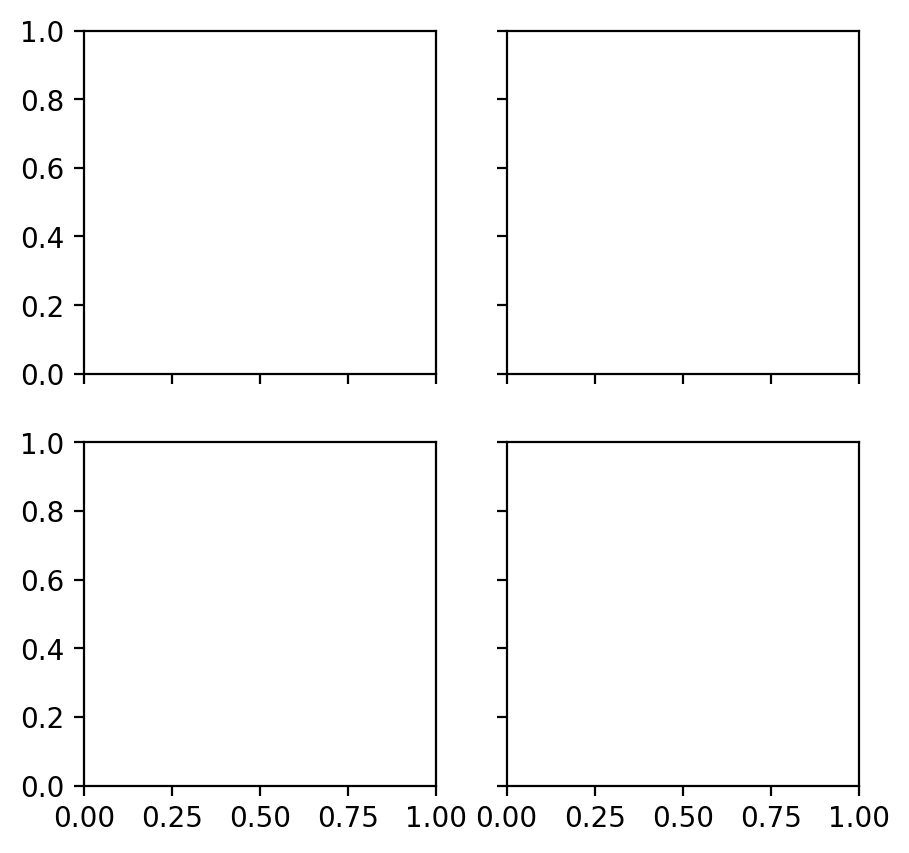

In [24]:
fig, axs = plt.subplots(2,2,figsize=(5,5),dpi=200,sharey=True, sharex=True)

cols = [f'wss_{s}' for s in s_crit] + [f'recall_{s}' for s in s_crit]

#pdf = results_df[results_df['data_source']=="copd_pb"][cols].dropna()
#pdf = results_df[results_df['data_source']=="copd_pb"][cols].dropna()
pdf = results_df

s_crit = ["bir","ih_100", "hyper", "nrs"]

for i, ss in enumerate(s_crit):
    ax = axs[i//2][i%2]
    ax.hexbin(
        pdf[f'wss_{ss}'].dropna(), 
        pdf[f'recall_{ss}'].dropna(), 
        gridsize=40, 
        mincnt=1,
        cmap="YlOrRd",
        bins="log",
        extent=[0, 1, 0, 1],
        alpha=1
    )
    ax.set_title(ss)
    #ax.plot([0,1],[1,0], lw=0.5)
    ax.axhline(0.95, lw=0.5)
    
    if i//2==1:
        ax.set_xlabel("work saved")
    if i%2==0:
        ax.set_ylabel("recall")
    
plt.savefig("../images/results_hex_4.png", bbox_inches="tight")
plt.show()    

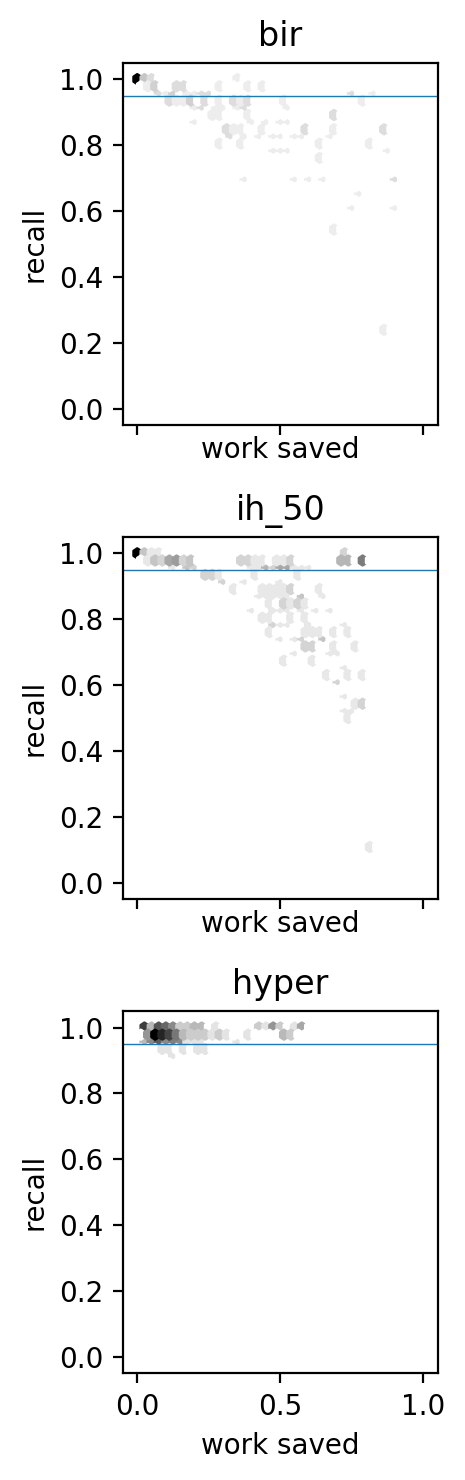

In [33]:
fig, axs = plt.subplots(3,figsize=(2.5,7.5),dpi=200,sharey=True, sharex=True)

cols = [f'wss95_{s}' for s in s_crit] + [f'recall_{s}' for s in s_crit]

#pdf = results_df[results_df['data_source']=="copd_pb"][cols].dropna()
#pdf = results_df[results_df['data_source']=="copd_pb"][cols].dropna()
pdf = results_df

s_crit = ["bir","ih_50","hyper"]

for i, ss in enumerate(s_crit):
    ax = axs[i]
    ax.hexbin(
        pdf[f'wss_{ss}'].dropna(), 
        pdf[f'recall_{ss}'].dropna(), 
        gridsize=40, 
        mincnt=0,
        cmap="Greys",
        bins="log",
        extent=[0, 1, 0, 1]
    )
    ax.set_title(ss)
    #ax.plot([0,1],[1,0], lw=0.5)
    ax.axhline(0.95, lw=0.5)

    ax.set_xlabel("work saved")
    ax.set_ylabel("recall")
    
fig.tight_layout()
    
plt.savefig("../images/results_hex_vert.png")
plt.show()    

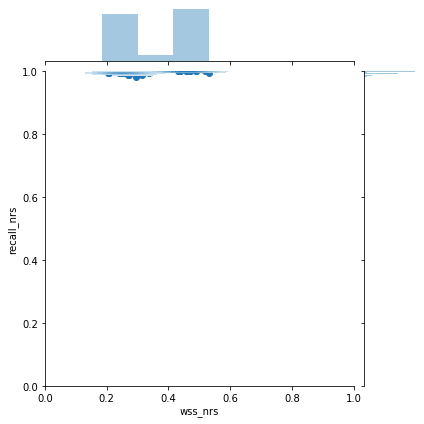

In [26]:
import seaborn as sns

g = (sns.jointplot(
        results_df['wss_nrs'], results_df['recall_nrs'],
        xlim=(0,1), ylim=(0,1)
    ).plot_joint(
    sns.kdeplot, shade=True, shade_lowest=False
))

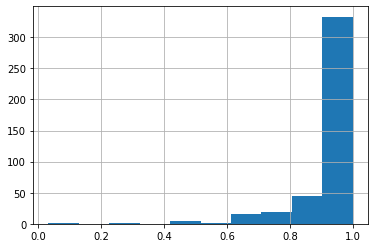

In [32]:
results_df['recall_bir'].hist()

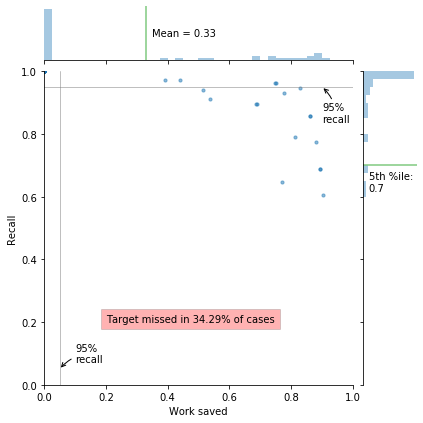

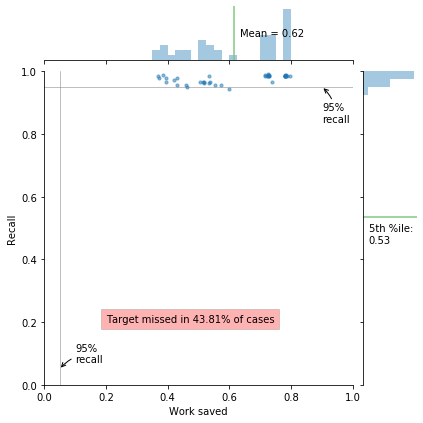

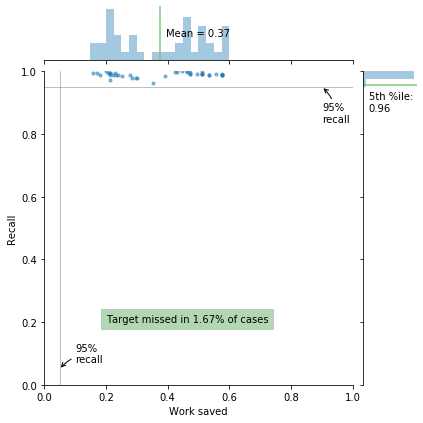

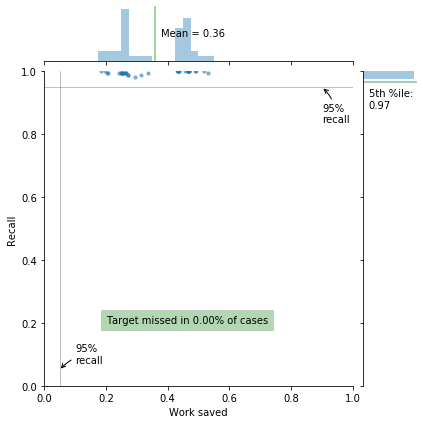

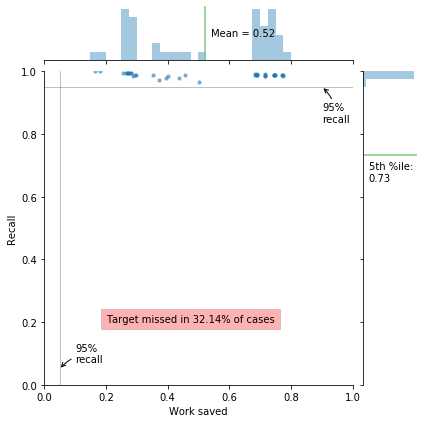

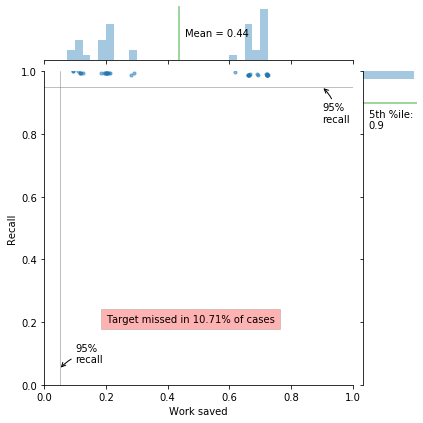

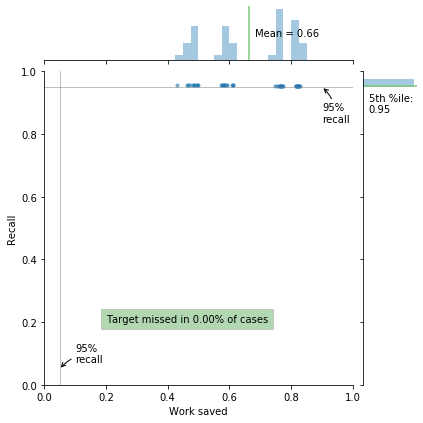

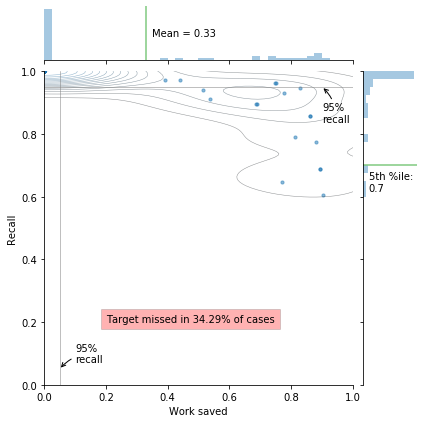

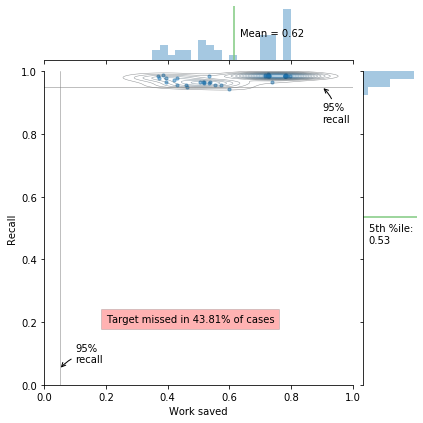

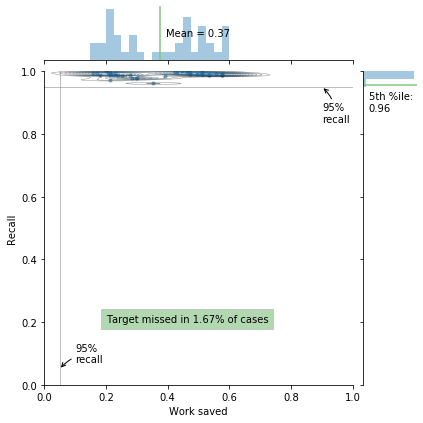

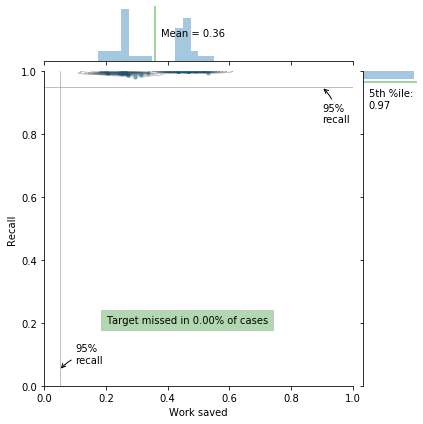

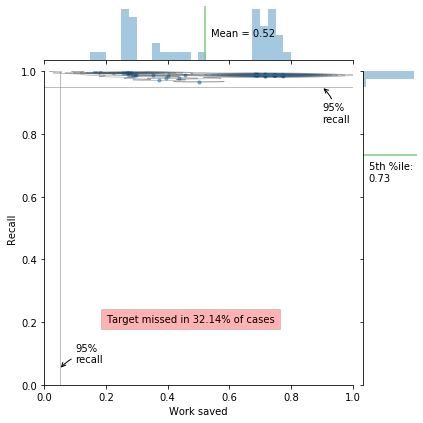

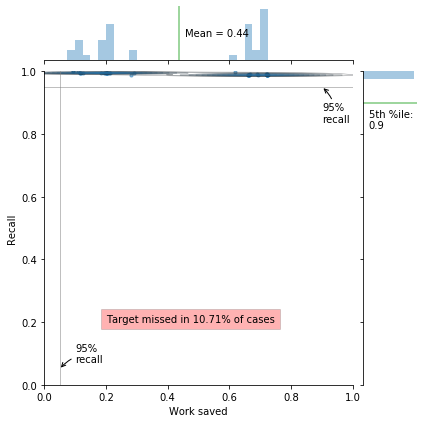

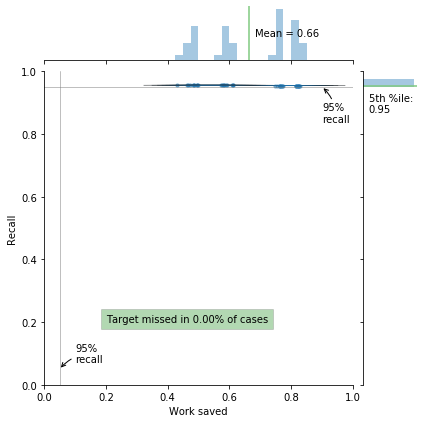

In [28]:
for kde in [False, True]:
    for ss in ["bir", "ih_50", "hyper", "nrs", "ih_100","ih_200", "pf"]:
        if kde:
            g = (sns.jointplot(
                    results_df[f'wss_{ss}'], results_df[f'recall_{ss}'],
                    xlim=(0,1), ylim=(0,1), alpha=0.5, s=10,
                    marginal_kws={
                        "bins": np.arange(41)/40
                    }
            ).plot_joint(
                sns.kdeplot, n_levels=20, linewidths=0.5, alpha=0.5
                )
            )   
        else:
            g = (sns.jointplot(
                    results_df[f'wss_{ss}'], results_df[f'recall_{ss}'],
                    xlim=(0,1), ylim=(0,1), alpha=0.5, s=10,
                    marginal_kws={
                        "bins": np.arange(41)/40
                    }
            ))        
        g.ax_joint.axvline(0.05, lw=0.5,c="grey")
        g.ax_joint.axhline(0.95, lw=0.5,c="grey")
        g.ax_joint.set_xlabel("Work saved")
        g.ax_joint.set_ylabel("Recall")

        g.ax_marg_x.axvline(results_df[f'wss_{ss}'].mean(), c="#7fc97f")
        g.ax_marg_x.text(results_df[f'wss_{ss}'].mean()+0.02, g.ax_marg_x.get_ylim()[1]/2,f"Mean = {results_df[f'wss_{ss}'].mean():.2}", va="center")
        
        #g.ax_marg_x.text(results_df[f'wss_{ss}'].median()+0.02, g.ax_marg_x.get_ylim()[1]*1,f"Median = {results_df[f'wss_{ss}'].median():.2}", va="center")


        g.ax_marg_y.axhline(results_df[f'recall_{ss}'].quantile(0.05), c="#7fc97f")
        g.ax_marg_y.text(
            g.ax_marg_y.get_xlim()[1]*0.1, 
            results_df[f'recall_{ss}'].quantile(0.05)-0.02,
            f"5th %ile:\n{results_df[f'recall_{ss}'].quantile(0.05):.2}", va="top")

        missed = results_df[results_df[f'recall_{ss}']<0.95].shape[0] / results_df[results_df[f'recall_{ss}']<1.01].shape[0]
        
        if missed < 0.05:
            bc = "green"
        else:
            bc = "red"

        g.ax_joint.text(0.2,0.2, f"Target missed in {missed:.2%} of cases",
                       bbox={'facecolor': bc, 'alpha': 0.3, 'pad': 5,
                             'edgecolor': "grey"
                            }
                       )

        g.ax_joint.annotate("95%\nrecall", (0.9,0.95), (0.9,0.9), va="top",
                           arrowprops=dict(arrowstyle="->",
                                    connectionstyle="arc3,rad=.2")
                           )

        g.ax_joint.annotate("95%\nrecall", (0.05,0.05), (0.1,0.1), va="center",
                       arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3,rad=.2")
                       )
        if kde:
            plt.savefig(f"../images/jointplot_kde_{ss}.png")
        else:
            plt.savefig(f"../images/jointplot_{ss}.png")

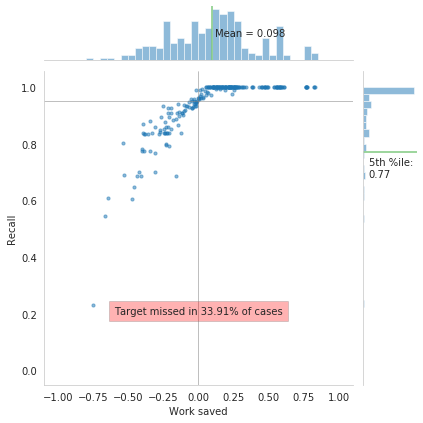

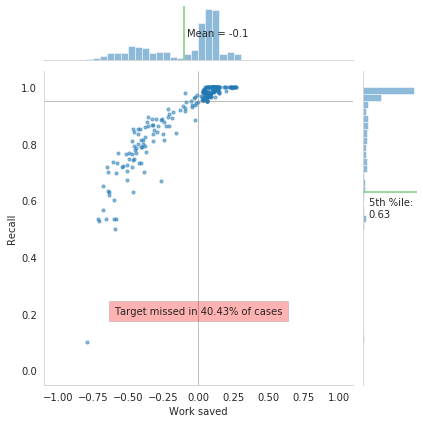

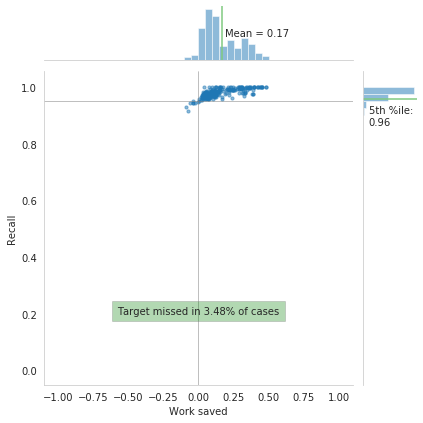

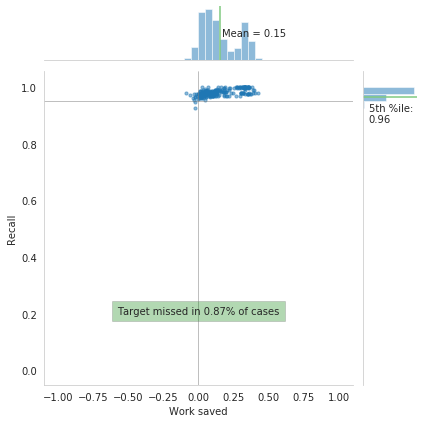

In [156]:


for kde in [False]:#, True]:
    for ss in ["bir", "ih_50", "hyper", "nrs"]:#, "ih_100","ih_200"]:
        results_df[f'additional_burden_{ss}'] = (results_df["wss_pf"] -  results_df[f"wss_{ss}"]) #/ results_df["wss_pf"]
        results_df = results_df.reset_index(drop=True)
        #results_df[f'additional_burden_{ss}'] = np.log(results_df["wss_pf"] / results_df[f"wss_{ss}"] ) / #np.log(results_df["wss_pf"])

        results_df.loc[results_df[f'additional_burden_{ss}'] < 0, f'additional_burden_{ss}'] = (results_df["wss_pf"] -  results_df[f"wss_{ss}"]) / (1 - results_df["wss_pf"])
        if kde:
            g = (sns.jointplot(
                    results_df[f'additional_burden_{ss}'], results_df[f'recall_{ss}'],
                    xlim=(-1,1), 
                    ylim=(0,1), 
                    alpha=0.5, s=10,
                    marginal_kws={
                        "bins": 40
                    }
            ).plot_joint(
                sns.kdeplot, n_levels=20, linewidths=0.5, alpha=0.5
                )
            )   
        elif kde:
            g = (sns.jointplot(
                    results_df[f'additional_burden_{ss}'], results_df[f'recall_{ss}'],
                    #xlim=(0,1), 
                    ylim=(0,1), 
                    alpha=0.5, s=10,
                    marginal_kws={
                        "bins": 40
                    }
            ))       
            
        g = sns.JointGrid(
            x=f'additional_burden_{ss}', y=f'recall_{ss}', data=results_df
        )
        g = g.plot_joint(plt.scatter, alpha=0.5, s=10)
        _ = g.ax_marg_x.hist(results_df[f'additional_burden_{ss}'], 
                              bins=(np.arange(41)-20)/20,
                             alpha=0.5,
                            )
        _ = g.ax_marg_y.hist(results_df[f'recall_{ss}'], 
                              orientation="horizontal",
                             alpha=0.5,
                              bins=np.arange(41)/40)


        g.ax_joint.axvline(0.0, lw=0.5,c="grey")
        g.ax_joint.axhline(0.95, lw=0.5,c="grey")
        g.ax_joint.set_xlabel("Work saved")
        g.ax_joint.set_ylabel("Recall")

        g.ax_marg_x.axvline(results_df[f'additional_burden_{ss}'].mean(), c="#7fc97f")
        g.ax_marg_x.text(results_df[f'additional_burden_{ss}'].mean()+0.02, g.ax_marg_x.get_ylim()[1]/2,f"Mean = {results_df[f'additional_burden_{ss}'].mean():.2}", va="center")
        
        #g.ax_marg_x.text(results_df[f'wss_{ss}'].median()+0.02, g.ax_marg_x.get_ylim()[1]*1,f"Median = {results_df[f'wss_{ss}'].median():.2}", va="center")


        g.ax_marg_y.axhline(results_df[f'recall_{ss}'].quantile(0.05), c="#7fc97f")
        g.ax_marg_y.text(
            g.ax_marg_y.get_xlim()[1]*0.1, 
            results_df[f'recall_{ss}'].quantile(0.05)-0.02,
            f"5th %ile:\n{results_df[f'recall_{ss}'].quantile(0.05):.2}", va="top")

        missed = results_df[results_df[f'recall_{ss}']<0.95].shape[0] / results_df[results_df[f'recall_{ss}']<1.01].shape[0]
        
        if missed < 0.05:
            bc = "green"
        else:
            bc = "red"

        g.ax_joint.text(0,0.2, f"Target missed in {missed:.2%} of cases",
                       bbox={'facecolor': bc, 'alpha': 0.3, 'pad': 5,
                             'edgecolor': "grey"
                            },
                        ha="center"
                       )
        if kde:
            plt.savefig(f"../images/jointplot_burden_kde_{ss}.png")
        else:
            plt.savefig(f"../images/jointplot_burden_{ss}.png")

## Explaining extra burden

In [33]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [39]:
results = smf.ols('additional_burden_nrs ~ N + p', data=results_df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     additional_burden_nrs   R-squared:                       0.224
Model:                               OLS   Adj. R-squared:                  0.204
Method:                    Least Squares   F-statistic:                     10.99
Date:                   Wed, 23 Oct 2019   Prob (F-statistic):            0.00203
Time:                           12:14:00   Log-Likelihood:                 66.302
No. Observations:                     40   AIC:                            -128.6
Df Residuals:                         38   BIC:                            -125.2
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2467      0.017     14.634      0.000       0.213       0.281
N           1.958e-05   5.56e-06      3.525      0.001    8.33e-06    3.08e-05
p              0.0394      0.003     14.634      0.000       0.034       0.045
==============================================================================
Omnibus:                        4.749   Durbin-Watson:                   1.041
Prob(Omnibus):                  0.093   Jarque-Bera (JB):                3.999
Skew:                          -0.773   Prob(JB):                        0.135
Kurtosis:                       3.079   Cond. No.                     5.04e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.49e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

[]

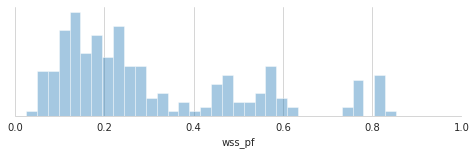

In [66]:
fig, ax = plt.subplots(figsize=(8,2))

sns.distplot(results_df['wss_pf'],ax=ax,bins=np.arange(40)/41,kde=False)

ax.grid(None)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_xlim(0,1)

ax.set_yticks([])


#ax.set_xticks([])

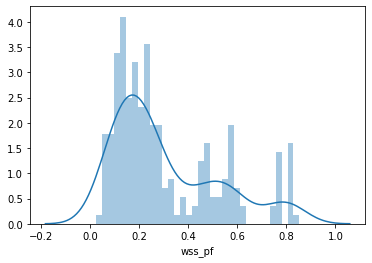

In [60]:
sns.distplot(results_df['wss_pf'],bins=np.arange(40)/41)


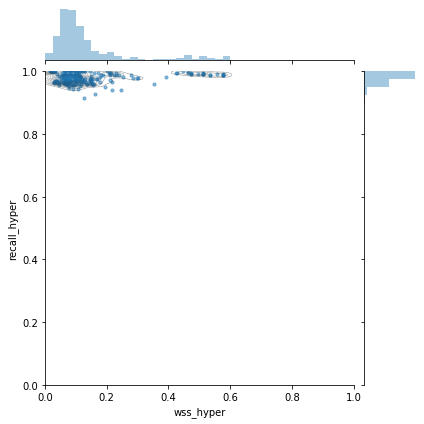

In [39]:
ss = "hyper"

g = (sns.jointplot(
        results_df[f'wss_{ss}'], results_df[f'recall_{ss}'],
        xlim=(0,1), ylim=(0,1), alpha=0.5, s=10,
        marginal_kws={
            "bins": np.arange(41)/40
        }
    ).plot_joint(
    sns.kdeplot, n_levels=20, linewidths=0.5, alpha=0.5
))

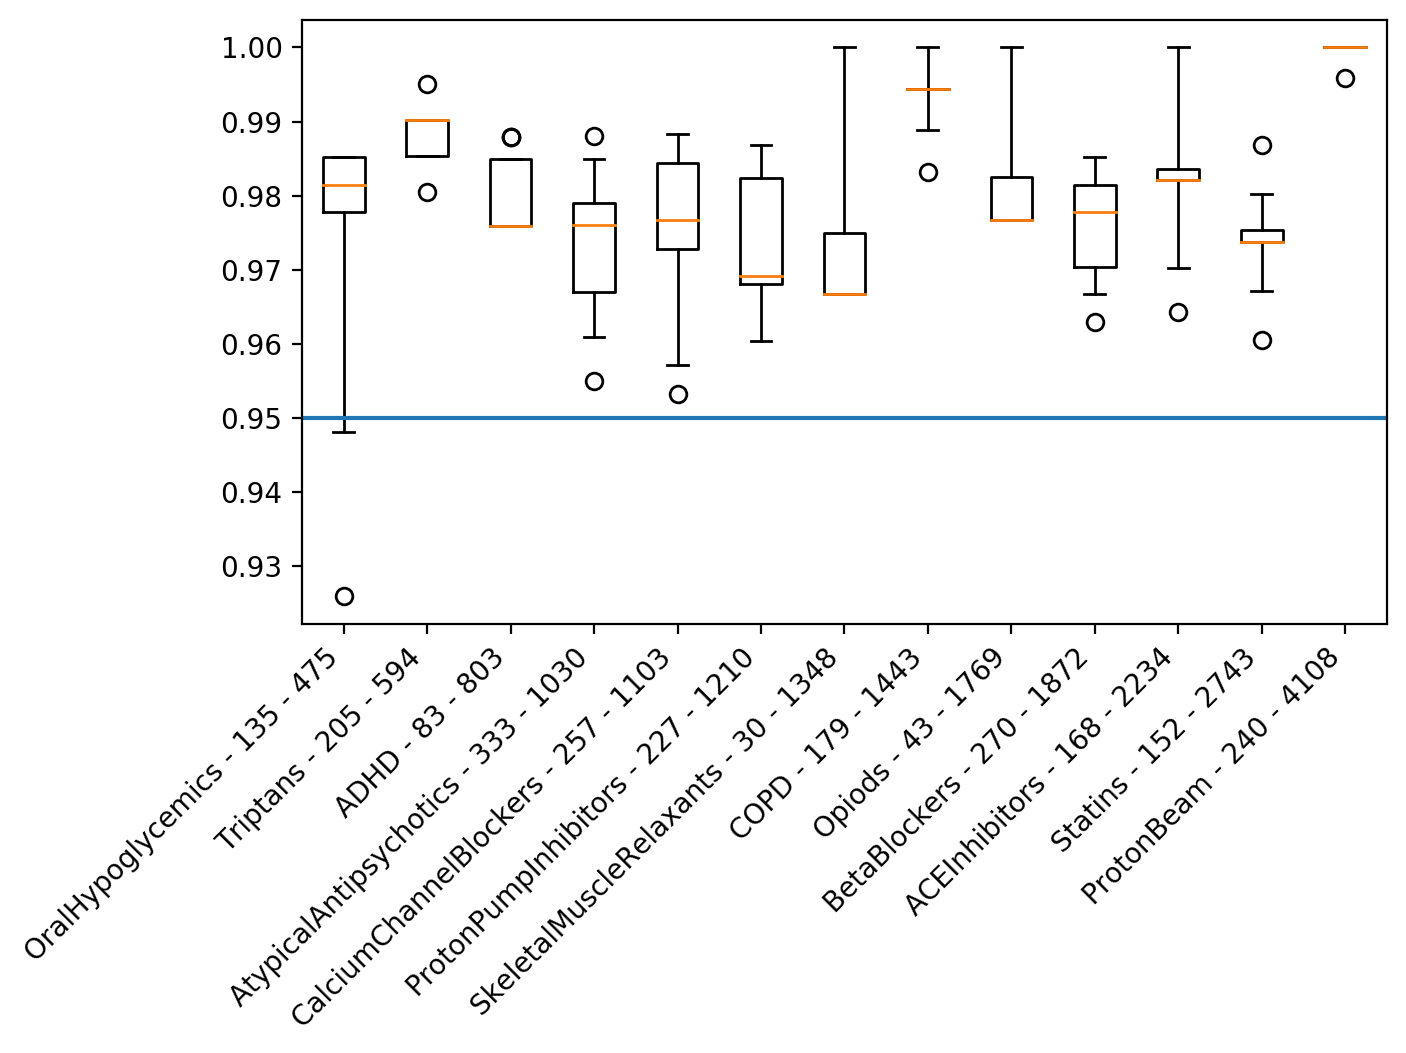

In [40]:
fig, ax = plt.subplots(figsize=(7,4),dpi=200)

datasets = results_df.groupby(['dataset','r_docs','N']).size().reset_index().sort_values('N')

datasets['label'] = datasets['dataset'].str.cat([datasets['r_docs'].astype(str), datasets['N'].astype(str)], sep = " - ")

ax.boxplot([results_df[results_df['dataset']==d]['recall_nrs'].dropna() for d in datasets['dataset']], whis=[5,95])

ax.set_xticklabels(datasets['label'], rotation=45,ha="right")

ax.axhline(0.95)

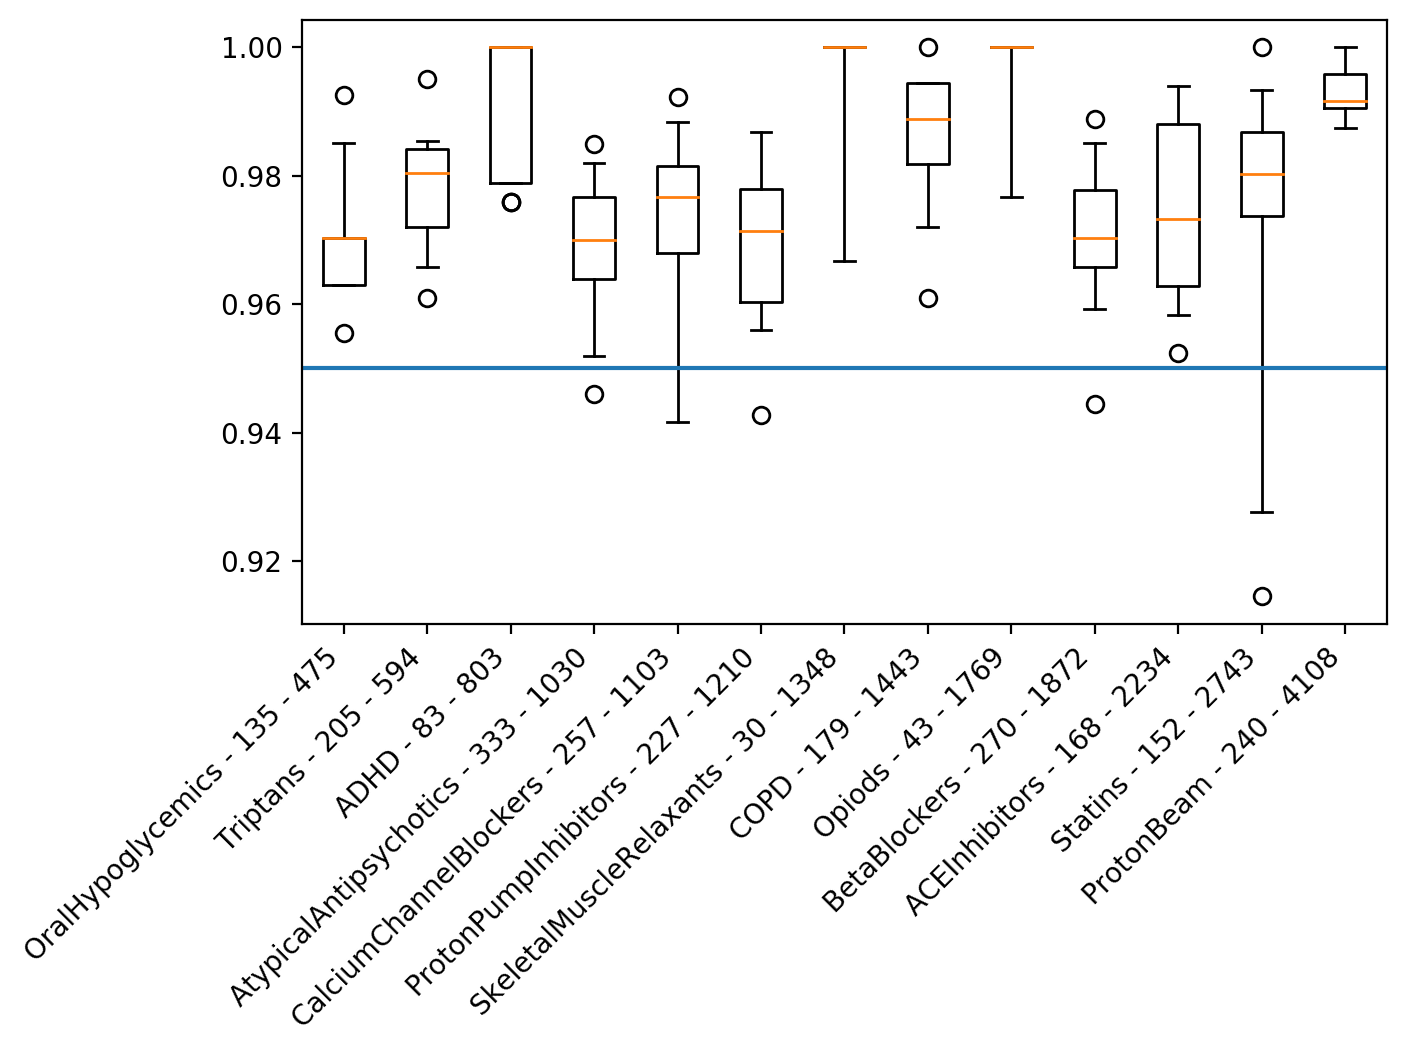

In [41]:
fig, ax = plt.subplots(figsize=(7,4),dpi=200)

datasets = results_df.groupby(['dataset','r_docs','N']).size().reset_index().sort_values('N')

datasets['label'] = datasets['dataset'].str.cat([datasets['r_docs'].astype(str), datasets['N'].astype(str)], sep = " - ")

ax.boxplot([results_df[results_df['dataset']==d]['recall_hyper'].dropna() for d in datasets['dataset']], whis=[5,95])

ax.set_xticklabels(datasets['label'], rotation=45,ha="right")

ax.axhline(0.95)

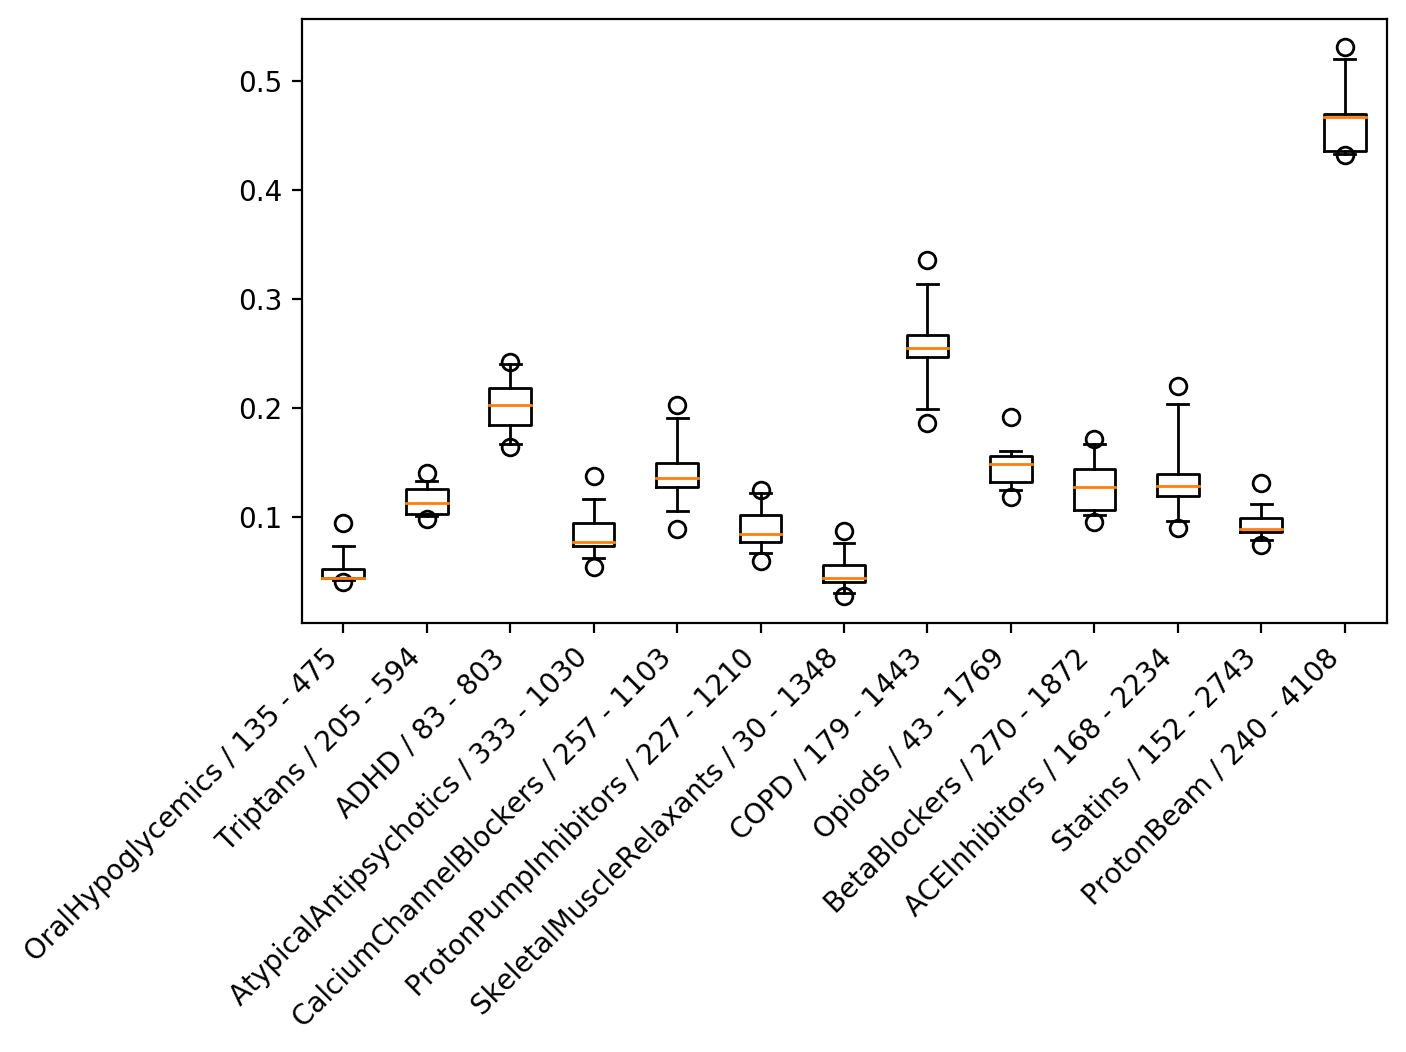

In [42]:
fig, ax = plt.subplots(figsize=(7,4),dpi=200)

pdf = results_df#[results_df['N'] > 1000]

datasets = results_df.groupby(['dataset','N','r_docs']).size().reset_index().sort_values('N')

datasets['label'] = datasets['dataset'].str.cat(datasets['r_docs'].astype(str), sep = " / ").str.cat(datasets['N'].astype(str), sep = " - ")


ax.boxplot([results_df[results_df['dataset']==d]['wss_nrs'].dropna() for d in datasets['dataset']], whis=[5,95])

ax.set_xticklabels(datasets['label'], rotation=45,ha="right")

plt.show()

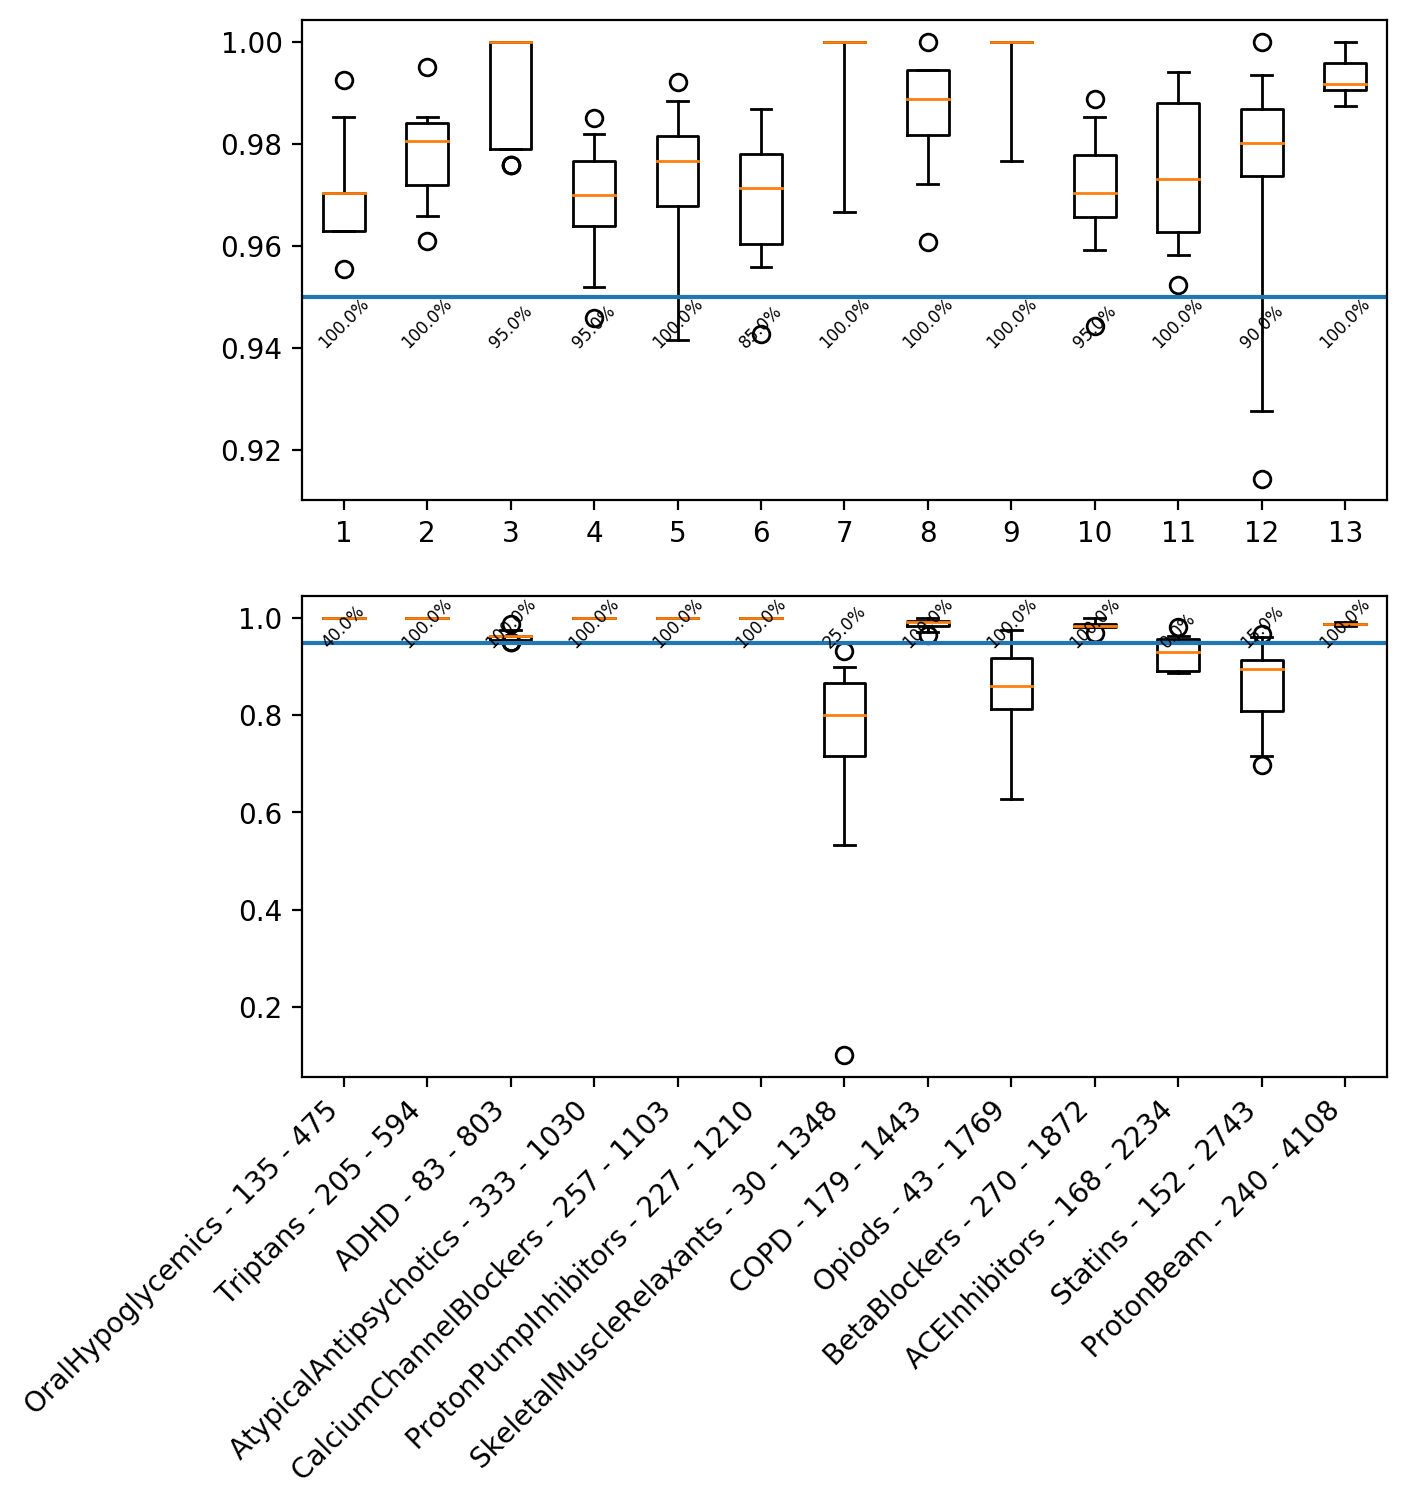

In [43]:
fig, axs = plt.subplots(2, figsize=(7,7),dpi=200)

datasets = results_df.groupby(['dataset','r_docs','N']).size().reset_index().sort_values('N')

datasets['label'] = datasets['dataset'].str.cat([datasets['r_docs'].astype(str), datasets['N'].astype(str)], sep = " - ")

ax = axs[0]

ax.boxplot([results_df[results_df['dataset']==d]['recall_hyper'].dropna() for d in datasets['dataset']], whis=[5,95])

for i, (name, d) in enumerate(results_df.groupby('dataset')):
    p = d[d['recall_hyper']>0.95].shape[0]/d.shape[0]
    ax.text(i+1,0.94, f"{p:.1%}",fontsize=6,ha="center",rotation=45)
    
ax.axhline(0.95)    
    
ax = axs[1]


ax.boxplot([results_df[results_df['dataset']==d]['recall_ih_100'].dropna() for d in datasets['dataset']], whis=[5,95])

for i, (name, d) in enumerate(results_df.groupby('dataset')):
    p = d[d['recall_ih_100']>0.95].shape[0]/d.shape[0]
    ax.text(i+1,0.94, f"{p:.1%}",fontsize=6,ha="center",rotation=45)
    

ax.set_xticklabels(datasets['label'], rotation=45,ha="right")

ax.axhline(0.95)

[Text(0, 0, 'OralHypoglycemics - 135 - 475'),
 Text(0, 0, 'Triptans - 205 - 594'),
 Text(0, 0, 'ADHD - 83 - 803'),
 Text(0, 0, 'AtypicalAntipsychotics - 333 - 1030'),
 Text(0, 0, 'CalciumChannelBlockers - 257 - 1103'),
 Text(0, 0, 'ProtonPumpInhibitors - 227 - 1210'),
 Text(0, 0, 'SkeletalMuscleRelaxants - 30 - 1348'),
 Text(0, 0, 'COPD - 179 - 1443'),
 Text(0, 0, 'Opiods - 43 - 1769'),
 Text(0, 0, 'BetaBlockers - 270 - 1872'),
 Text(0, 0, 'ACEInhibitors - 168 - 2234'),
 Text(0, 0, 'Statins - 152 - 2743'),
 Text(0, 0, 'ProtonBeam - 240 - 4108')]

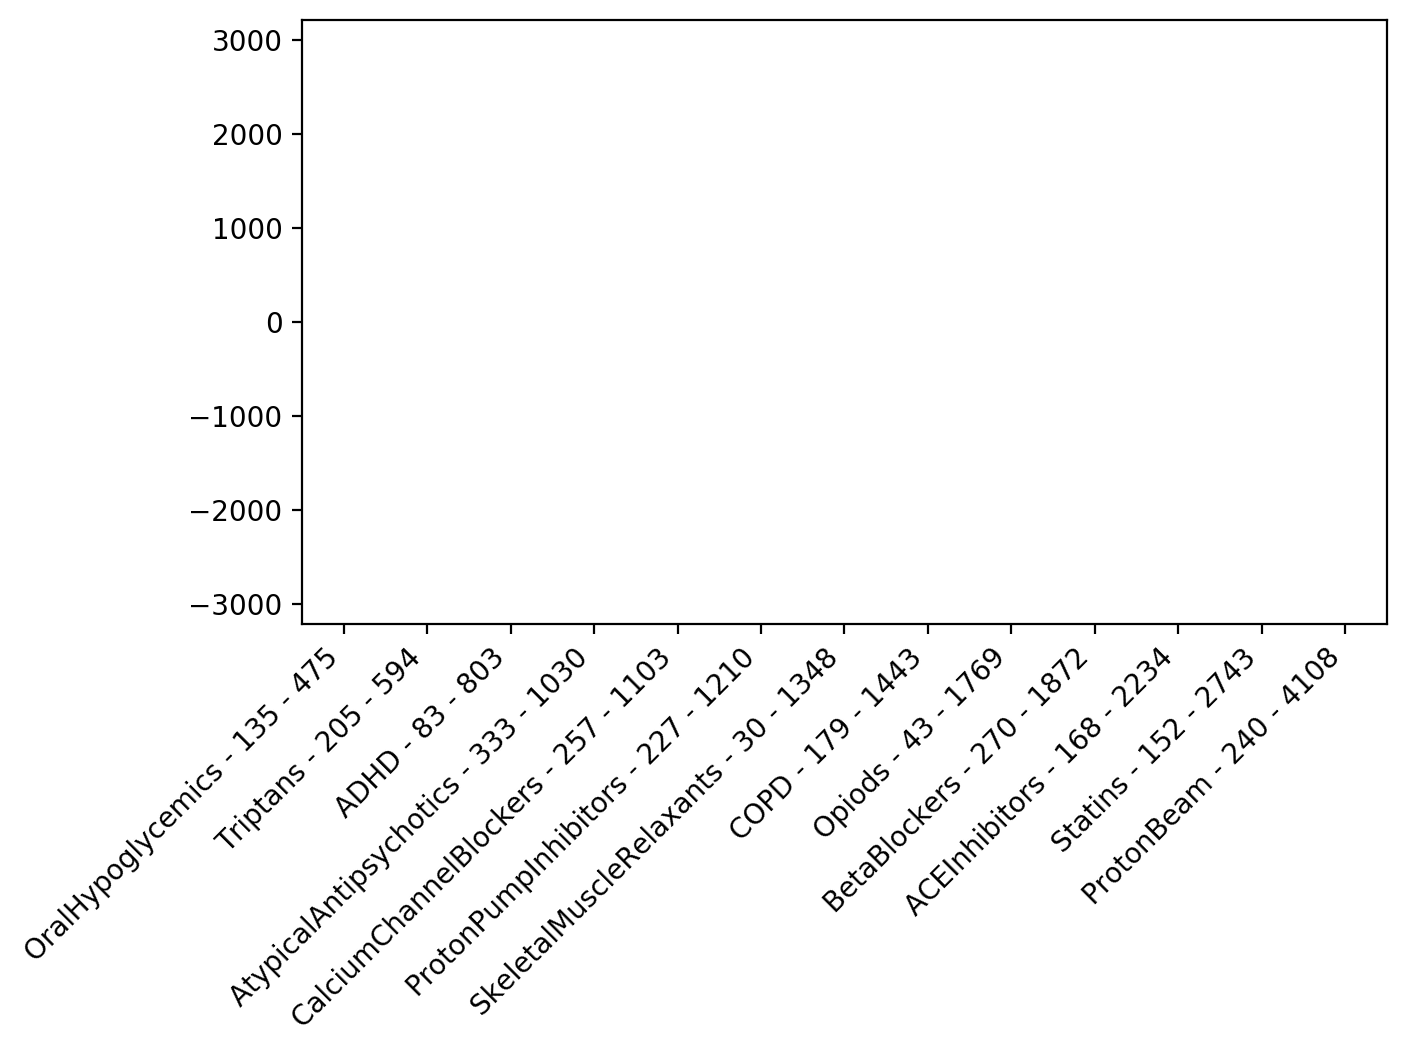

In [45]:
fig, ax = plt.subplots(figsize=(7,4),dpi=200)

pdf = results_df[results_df['N'] > 1000]

datasets = results_df.groupby(['dataset','r_docs','N']).size().reset_index().sort_values('N')

datasets['label'] = datasets['dataset'].str.cat([datasets['r_docs'].astype(str), datasets['N'].astype(str)], sep = " - ")

ax.boxplot([results_df[results_df['dataset']==d]['wss_rs'].dropna() for d in datasets['dataset']], whis=[5,95])

ax.set_xticklabels(datasets['label'], rotation=45,ha="right")

In [ ]:
fig, ax = plt.subplots(figsize=(7,4),dpi=200)

pdf = results_df[results_df['N'] > 1000]

datasets = results_df.groupby(['dataset','N']).size().reset_index().sort_values('N')

datasets['label'] = datasets['dataset'].str.cat(datasets['N'].astype(str), sep = " - ")

ax.boxplot([results_df[results_df['dataset']==d]['wss95_hyper'].dropna() for d in datasets['dataset']], whis=[5,95])

ax.set_xticklabels(datasets['label'], rotation=45,ha="right")

In [ ]:
fig, ax = plt.subplots(figsize=(7,4),dpi=200)

pdf = results_df#[results_df['N'] > 1000]

datasets = results_df.groupby(['dataset','N','r_docs']).size().reset_index().sort_values('N')

datasets['label'] = datasets['dataset'].str.cat(datasets['r_docs'].astype(str), sep = " / ").str.cat(datasets['N'].astype(str), sep = " - ")


ax.boxplot([results_df[results_df['dataset']==d]['ab_s_hyper'].dropna() for d in datasets['dataset']], whis=[5,95])

ax.set_xticklabels(datasets['label'], rotation=45,ha="right")

In [ ]:
fig, ax = plt.subplots(figsize=(7,4),dpi=200)

pdf = results_df#[results_df['N'] > 1000]

datasets = results_df.groupby(['dataset','N','r_docs']).size().reset_index().sort_values('N')

datasets['label'] = datasets['dataset'].str.cat(datasets['r_docs'].astype(str), sep = " / ").str.cat(datasets['N'].astype(str), sep = " - ")


ax.boxplot([results_df[results_df['dataset']==d]['ab_s_ih_50'].dropna() for d in datasets['dataset']], whis=[5,95])

ax.set_xticklabels(datasets['label'], rotation=45,ha="right")